# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = 'data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

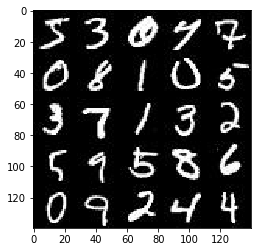

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

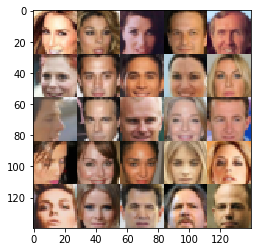

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 
                                name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    # Applying batch learning below for 2nd and 3rd convolutional network and setting training to True
    # Setting training to True is finee here because we are only interested in using the 
    # discriminator to help train the generator so that we can see the generator images as it trains
    # If we had to use the discriminator for inference in this project, then we would need to set
    # the training parameter to False and so include this as an input parameter to the 
    # discriminator function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layer is 28 * 28 * out_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14*14*64 now
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7*7*128 now
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4*4*256 now
        
        # Flatten this
        final = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(final, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.001
    
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        # Reshape to create the 7*7*512 shape of convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same', activation = None)
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14*14*256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 1, padding = 'same', activation = None)
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha *x3, x3)
        # 14*14*128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides = 1, padding = 'same', activation = None)
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum(alpha *x4, x4)
        # 14*14*128 now
        
        # output Layer, 28 * 28 * out_channel_dim
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides = 2, padding = 'same',
                                           activation = None)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    label_smooth = 0.95
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                labels = tf.ones_like(d_model_real)*label_smooth ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                labels = tf.zeros_like(d_model_fake)*label_smooth))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                labels = tf.ones_like(d_model_fake)*label_smooth ))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1 
                
                # Normalizing the batch images to -1 to 1 in line with the range of tanh, the output of the generator
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimization
                _ = sess.run(d_opt, feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z
                })
                
                _ = sess.run(g_opt, feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z
                })
                
                # After print_every steps, get the losses and print them
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})
                    print ('Epoch {}/{} ... '.format(epoch_i+1, epoch_count),
                          'Discriminator Loss: {:.4f}'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                
                # After show_every steps, show the generator output
                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
    return


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ...  Discriminator Loss: 1.3182 Generator Loss: 0.7001
Epoch 1/2 ...  Discriminator Loss: 0.7783 Generator Loss: 4.6395
Epoch 1/2 ...  Discriminator Loss: 1.0004 Generator Loss: 0.8329
Epoch 1/2 ...  Discriminator Loss: 0.4043 Generator Loss: 2.7415
Epoch 1/2 ...  Discriminator Loss: 1.1562 Generator Loss: 1.2045
Epoch 1/2 ...  Discriminator Loss: 2.4343 Generator Loss: 0.2710
Epoch 1/2 ...  Discriminator Loss: 1.2218 Generator Loss: 0.6379
Epoch 1/2 ...  Discriminator Loss: 1.1804 Generator Loss: 0.8580
Epoch 1/2 ...  Discriminator Loss: 1.1834 Generator Loss: 3.1175
Epoch 1/2 ...  Discriminator Loss: 1.8779 Generator Loss: 0.5142


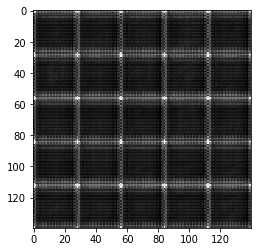

Epoch 1/2 ...  Discriminator Loss: 2.0700 Generator Loss: 0.4418
Epoch 1/2 ...  Discriminator Loss: 0.9118 Generator Loss: 1.6212
Epoch 1/2 ...  Discriminator Loss: 1.3238 Generator Loss: 0.8404
Epoch 1/2 ...  Discriminator Loss: 1.1451 Generator Loss: 0.8915
Epoch 1/2 ...  Discriminator Loss: 1.2740 Generator Loss: 1.8472
Epoch 1/2 ...  Discriminator Loss: 1.1136 Generator Loss: 0.6966
Epoch 1/2 ...  Discriminator Loss: 1.4986 Generator Loss: 0.4424
Epoch 1/2 ...  Discriminator Loss: 1.3679 Generator Loss: 0.7368
Epoch 1/2 ...  Discriminator Loss: 1.1861 Generator Loss: 1.3618
Epoch 1/2 ...  Discriminator Loss: 1.3473 Generator Loss: 0.7911


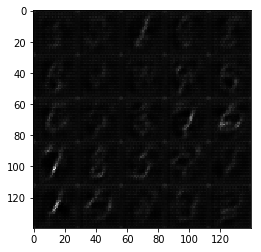

Epoch 1/2 ...  Discriminator Loss: 1.3075 Generator Loss: 0.9466
Epoch 1/2 ...  Discriminator Loss: 1.2086 Generator Loss: 1.1427
Epoch 1/2 ...  Discriminator Loss: 1.2661 Generator Loss: 0.7264
Epoch 1/2 ...  Discriminator Loss: 1.4974 Generator Loss: 0.4100
Epoch 1/2 ...  Discriminator Loss: 1.3194 Generator Loss: 0.8867
Epoch 1/2 ...  Discriminator Loss: 1.1105 Generator Loss: 0.8602
Epoch 1/2 ...  Discriminator Loss: 1.2332 Generator Loss: 0.7818
Epoch 1/2 ...  Discriminator Loss: 1.2926 Generator Loss: 0.6192
Epoch 1/2 ...  Discriminator Loss: 1.4980 Generator Loss: 0.4508
Epoch 1/2 ...  Discriminator Loss: 1.2425 Generator Loss: 0.7228


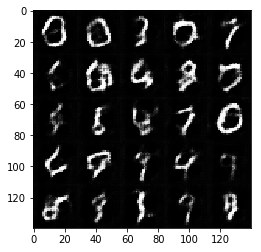

Epoch 1/2 ...  Discriminator Loss: 1.3098 Generator Loss: 0.5455
Epoch 1/2 ...  Discriminator Loss: 1.4613 Generator Loss: 0.4709
Epoch 1/2 ...  Discriminator Loss: 1.2412 Generator Loss: 0.6884
Epoch 1/2 ...  Discriminator Loss: 1.1033 Generator Loss: 1.2208
Epoch 1/2 ...  Discriminator Loss: 1.2424 Generator Loss: 0.7838
Epoch 1/2 ...  Discriminator Loss: 1.3833 Generator Loss: 0.5150
Epoch 1/2 ...  Discriminator Loss: 1.3072 Generator Loss: 0.5843
Epoch 1/2 ...  Discriminator Loss: 1.3716 Generator Loss: 0.5213
Epoch 1/2 ...  Discriminator Loss: 1.0730 Generator Loss: 0.7994
Epoch 1/2 ...  Discriminator Loss: 1.2774 Generator Loss: 0.5695


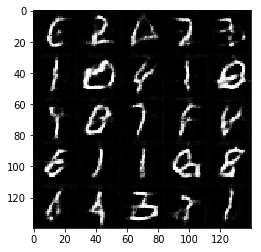

Epoch 1/2 ...  Discriminator Loss: 1.3904 Generator Loss: 0.5736
Epoch 1/2 ...  Discriminator Loss: 1.0964 Generator Loss: 1.7590
Epoch 1/2 ...  Discriminator Loss: 1.2702 Generator Loss: 0.7630
Epoch 1/2 ...  Discriminator Loss: 1.5259 Generator Loss: 0.4383
Epoch 1/2 ...  Discriminator Loss: 1.1050 Generator Loss: 0.6695
Epoch 1/2 ...  Discriminator Loss: 1.2141 Generator Loss: 0.7562
Epoch 1/2 ...  Discriminator Loss: 1.2933 Generator Loss: 0.5661
Epoch 1/2 ...  Discriminator Loss: 1.0440 Generator Loss: 1.1715
Epoch 1/2 ...  Discriminator Loss: 1.3793 Generator Loss: 0.5178
Epoch 1/2 ...  Discriminator Loss: 1.4348 Generator Loss: 0.4887


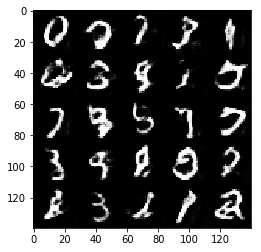

Epoch 1/2 ...  Discriminator Loss: 1.2661 Generator Loss: 0.6720
Epoch 1/2 ...  Discriminator Loss: 1.1265 Generator Loss: 0.9372
Epoch 1/2 ...  Discriminator Loss: 1.3128 Generator Loss: 1.0529
Epoch 1/2 ...  Discriminator Loss: 1.2810 Generator Loss: 0.5772
Epoch 1/2 ...  Discriminator Loss: 1.0050 Generator Loss: 1.1720
Epoch 1/2 ...  Discriminator Loss: 1.4020 Generator Loss: 1.4950
Epoch 1/2 ...  Discriminator Loss: 1.2658 Generator Loss: 0.7913
Epoch 1/2 ...  Discriminator Loss: 1.3895 Generator Loss: 0.5271
Epoch 1/2 ...  Discriminator Loss: 1.1838 Generator Loss: 0.6732
Epoch 1/2 ...  Discriminator Loss: 1.1978 Generator Loss: 0.6494


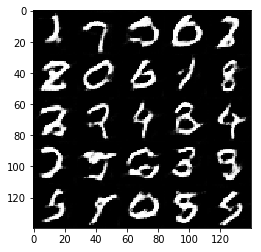

Epoch 1/2 ...  Discriminator Loss: 1.1575 Generator Loss: 0.7481
Epoch 1/2 ...  Discriminator Loss: 1.1404 Generator Loss: 0.9689
Epoch 1/2 ...  Discriminator Loss: 1.6012 Generator Loss: 0.4160
Epoch 1/2 ...  Discriminator Loss: 1.1764 Generator Loss: 0.9466
Epoch 1/2 ...  Discriminator Loss: 1.1468 Generator Loss: 1.0604
Epoch 1/2 ...  Discriminator Loss: 1.2179 Generator Loss: 0.7838
Epoch 1/2 ...  Discriminator Loss: 1.3120 Generator Loss: 0.5499
Epoch 1/2 ...  Discriminator Loss: 1.2561 Generator Loss: 1.2130
Epoch 1/2 ...  Discriminator Loss: 1.1023 Generator Loss: 0.8626
Epoch 1/2 ...  Discriminator Loss: 1.0323 Generator Loss: 1.2639


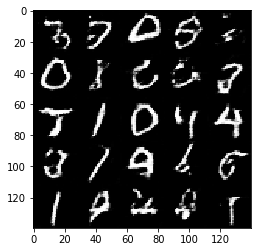

Epoch 1/2 ...  Discriminator Loss: 1.3230 Generator Loss: 0.5188
Epoch 1/2 ...  Discriminator Loss: 1.0843 Generator Loss: 1.2807
Epoch 1/2 ...  Discriminator Loss: 1.1060 Generator Loss: 1.0089
Epoch 1/2 ...  Discriminator Loss: 1.2222 Generator Loss: 0.7322
Epoch 1/2 ...  Discriminator Loss: 0.9532 Generator Loss: 1.3307
Epoch 1/2 ...  Discriminator Loss: 0.8100 Generator Loss: 1.4330
Epoch 1/2 ...  Discriminator Loss: 1.2945 Generator Loss: 0.8687
Epoch 1/2 ...  Discriminator Loss: 1.3089 Generator Loss: 0.8832
Epoch 1/2 ...  Discriminator Loss: 1.1735 Generator Loss: 0.7150
Epoch 1/2 ...  Discriminator Loss: 1.5358 Generator Loss: 0.4565


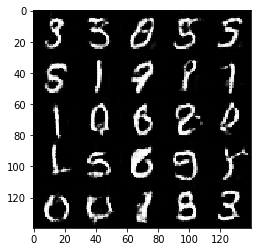

Epoch 1/2 ...  Discriminator Loss: 0.9201 Generator Loss: 1.0155
Epoch 1/2 ...  Discriminator Loss: 1.1007 Generator Loss: 0.8582
Epoch 1/2 ...  Discriminator Loss: 0.9744 Generator Loss: 0.9724
Epoch 1/2 ...  Discriminator Loss: 1.1316 Generator Loss: 0.9006
Epoch 1/2 ...  Discriminator Loss: 1.0927 Generator Loss: 0.7408
Epoch 1/2 ...  Discriminator Loss: 1.2753 Generator Loss: 0.6871
Epoch 1/2 ...  Discriminator Loss: 1.2863 Generator Loss: 0.5408
Epoch 1/2 ...  Discriminator Loss: 1.3985 Generator Loss: 0.4806
Epoch 1/2 ...  Discriminator Loss: 1.0739 Generator Loss: 0.8294
Epoch 1/2 ...  Discriminator Loss: 0.8137 Generator Loss: 1.1094


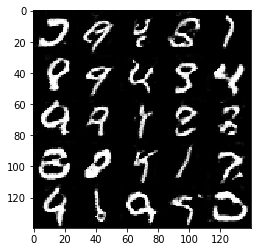

Epoch 1/2 ...  Discriminator Loss: 0.9767 Generator Loss: 1.0351
Epoch 1/2 ...  Discriminator Loss: 1.2791 Generator Loss: 0.6229
Epoch 1/2 ...  Discriminator Loss: 1.1268 Generator Loss: 0.8040
Epoch 1/2 ...  Discriminator Loss: 1.3366 Generator Loss: 0.5771
Epoch 1/2 ...  Discriminator Loss: 1.0175 Generator Loss: 1.1688
Epoch 1/2 ...  Discriminator Loss: 1.0063 Generator Loss: 1.0764
Epoch 1/2 ...  Discriminator Loss: 1.1560 Generator Loss: 0.7784
Epoch 1/2 ...  Discriminator Loss: 1.1023 Generator Loss: 1.2098
Epoch 1/2 ...  Discriminator Loss: 1.0818 Generator Loss: 0.7382
Epoch 1/2 ...  Discriminator Loss: 0.9579 Generator Loss: 0.8409


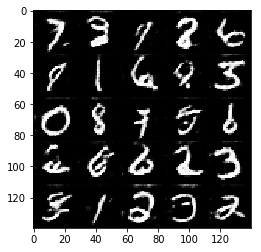

Epoch 1/2 ...  Discriminator Loss: 1.1788 Generator Loss: 0.6649
Epoch 1/2 ...  Discriminator Loss: 1.4404 Generator Loss: 0.4981
Epoch 1/2 ...  Discriminator Loss: 0.9599 Generator Loss: 0.8966
Epoch 1/2 ...  Discriminator Loss: 0.8995 Generator Loss: 1.0412
Epoch 1/2 ...  Discriminator Loss: 0.9820 Generator Loss: 1.3129
Epoch 1/2 ...  Discriminator Loss: 1.3481 Generator Loss: 0.5707
Epoch 1/2 ...  Discriminator Loss: 1.3078 Generator Loss: 0.5788
Epoch 1/2 ...  Discriminator Loss: 1.2692 Generator Loss: 0.6059
Epoch 1/2 ...  Discriminator Loss: 0.9791 Generator Loss: 0.9792
Epoch 1/2 ...  Discriminator Loss: 1.1699 Generator Loss: 0.9186


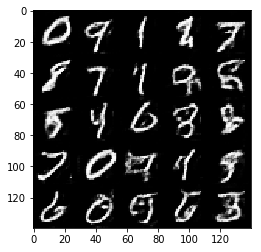

Epoch 1/2 ...  Discriminator Loss: 1.1519 Generator Loss: 0.8795
Epoch 1/2 ...  Discriminator Loss: 0.9326 Generator Loss: 0.9082
Epoch 1/2 ...  Discriminator Loss: 0.9509 Generator Loss: 0.9066
Epoch 1/2 ...  Discriminator Loss: 1.0508 Generator Loss: 1.0332
Epoch 1/2 ...  Discriminator Loss: 1.0828 Generator Loss: 1.3766
Epoch 1/2 ...  Discriminator Loss: 1.0431 Generator Loss: 0.9301
Epoch 1/2 ...  Discriminator Loss: 1.0825 Generator Loss: 0.7035
Epoch 1/2 ...  Discriminator Loss: 0.9083 Generator Loss: 1.1710
Epoch 1/2 ...  Discriminator Loss: 0.9784 Generator Loss: 0.8822
Epoch 1/2 ...  Discriminator Loss: 0.9609 Generator Loss: 1.6612


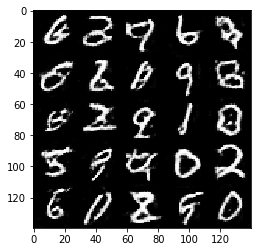

Epoch 1/2 ...  Discriminator Loss: 0.8670 Generator Loss: 1.1234
Epoch 1/2 ...  Discriminator Loss: 0.9200 Generator Loss: 1.3414
Epoch 1/2 ...  Discriminator Loss: 0.9420 Generator Loss: 0.8910
Epoch 1/2 ...  Discriminator Loss: 0.9561 Generator Loss: 0.9298
Epoch 1/2 ...  Discriminator Loss: 1.2364 Generator Loss: 0.5903
Epoch 1/2 ...  Discriminator Loss: 1.0456 Generator Loss: 0.8204
Epoch 1/2 ...  Discriminator Loss: 1.1339 Generator Loss: 0.7368
Epoch 1/2 ...  Discriminator Loss: 1.6087 Generator Loss: 0.3886
Epoch 1/2 ...  Discriminator Loss: 1.1237 Generator Loss: 1.0372
Epoch 1/2 ...  Discriminator Loss: 1.0905 Generator Loss: 0.9869


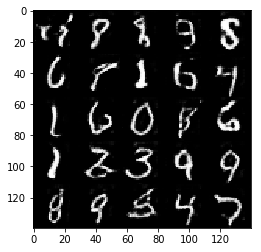

Epoch 1/2 ...  Discriminator Loss: 0.8992 Generator Loss: 1.3769
Epoch 1/2 ...  Discriminator Loss: 0.9201 Generator Loss: 0.9198
Epoch 1/2 ...  Discriminator Loss: 1.2500 Generator Loss: 0.5922
Epoch 1/2 ...  Discriminator Loss: 0.9697 Generator Loss: 0.9692
Epoch 1/2 ...  Discriminator Loss: 0.9494 Generator Loss: 0.8799
Epoch 1/2 ...  Discriminator Loss: 1.2563 Generator Loss: 0.6728
Epoch 1/2 ...  Discriminator Loss: 0.9035 Generator Loss: 1.0040
Epoch 1/2 ...  Discriminator Loss: 1.6598 Generator Loss: 0.3931
Epoch 1/2 ...  Discriminator Loss: 0.7167 Generator Loss: 1.3008
Epoch 1/2 ...  Discriminator Loss: 1.1099 Generator Loss: 0.6827


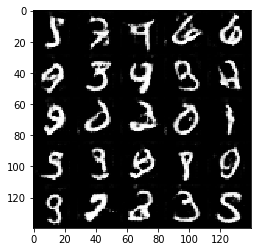

Epoch 1/2 ...  Discriminator Loss: 0.9743 Generator Loss: 1.0597
Epoch 1/2 ...  Discriminator Loss: 1.2287 Generator Loss: 0.5838
Epoch 1/2 ...  Discriminator Loss: 1.2177 Generator Loss: 0.6149
Epoch 1/2 ...  Discriminator Loss: 1.1201 Generator Loss: 0.8649
Epoch 1/2 ...  Discriminator Loss: 1.5152 Generator Loss: 0.4495
Epoch 1/2 ...  Discriminator Loss: 1.0504 Generator Loss: 0.8447
Epoch 1/2 ...  Discriminator Loss: 1.2370 Generator Loss: 0.6052
Epoch 1/2 ...  Discriminator Loss: 0.8450 Generator Loss: 1.1863
Epoch 1/2 ...  Discriminator Loss: 1.5169 Generator Loss: 0.4663
Epoch 1/2 ...  Discriminator Loss: 0.8090 Generator Loss: 1.1389


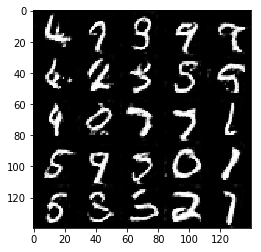

Epoch 1/2 ...  Discriminator Loss: 1.1837 Generator Loss: 0.6766
Epoch 1/2 ...  Discriminator Loss: 0.9008 Generator Loss: 1.0304
Epoch 1/2 ...  Discriminator Loss: 1.0238 Generator Loss: 1.2475
Epoch 1/2 ...  Discriminator Loss: 0.7602 Generator Loss: 1.1252
Epoch 1/2 ...  Discriminator Loss: 1.0908 Generator Loss: 0.6459
Epoch 1/2 ...  Discriminator Loss: 1.0179 Generator Loss: 0.7727
Epoch 1/2 ...  Discriminator Loss: 0.8666 Generator Loss: 1.2256
Epoch 1/2 ...  Discriminator Loss: 1.0836 Generator Loss: 0.7693
Epoch 1/2 ...  Discriminator Loss: 0.9800 Generator Loss: 0.7936
Epoch 1/2 ...  Discriminator Loss: 1.4161 Generator Loss: 0.4688


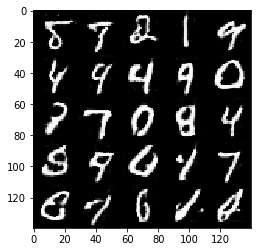

Epoch 1/2 ...  Discriminator Loss: 1.4664 Generator Loss: 0.4568
Epoch 1/2 ...  Discriminator Loss: 1.0505 Generator Loss: 0.8284
Epoch 1/2 ...  Discriminator Loss: 0.8678 Generator Loss: 1.3315
Epoch 1/2 ...  Discriminator Loss: 1.0371 Generator Loss: 0.8374
Epoch 1/2 ...  Discriminator Loss: 1.2195 Generator Loss: 0.6308
Epoch 1/2 ...  Discriminator Loss: 0.9524 Generator Loss: 1.2552
Epoch 1/2 ...  Discriminator Loss: 1.1938 Generator Loss: 0.6194
Epoch 1/2 ...  Discriminator Loss: 0.6990 Generator Loss: 1.3771
Epoch 1/2 ...  Discriminator Loss: 0.9275 Generator Loss: 0.8809
Epoch 1/2 ...  Discriminator Loss: 1.1351 Generator Loss: 0.6761


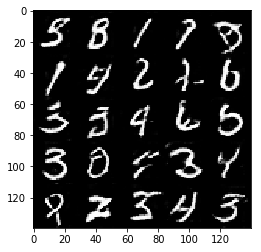

Epoch 1/2 ...  Discriminator Loss: 0.8259 Generator Loss: 1.2512
Epoch 1/2 ...  Discriminator Loss: 0.4366 Generator Loss: 1.9701
Epoch 1/2 ...  Discriminator Loss: 0.9476 Generator Loss: 1.6821
Epoch 1/2 ...  Discriminator Loss: 0.9876 Generator Loss: 1.0037
Epoch 1/2 ...  Discriminator Loss: 0.9303 Generator Loss: 1.2150
Epoch 1/2 ...  Discriminator Loss: 0.9829 Generator Loss: 0.9512
Epoch 1/2 ...  Discriminator Loss: 1.1489 Generator Loss: 0.7705
Epoch 1/2 ...  Discriminator Loss: 0.8856 Generator Loss: 1.3530
Epoch 1/2 ...  Discriminator Loss: 1.0008 Generator Loss: 1.1539
Epoch 1/2 ...  Discriminator Loss: 0.8520 Generator Loss: 1.0437


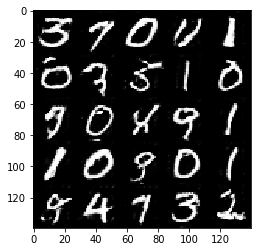

Epoch 1/2 ...  Discriminator Loss: 1.0612 Generator Loss: 0.8296
Epoch 1/2 ...  Discriminator Loss: 0.8620 Generator Loss: 0.9720
Epoch 1/2 ...  Discriminator Loss: 1.1457 Generator Loss: 1.0279
Epoch 1/2 ...  Discriminator Loss: 1.5377 Generator Loss: 0.4223
Epoch 1/2 ...  Discriminator Loss: 1.0085 Generator Loss: 1.0508
Epoch 1/2 ...  Discriminator Loss: 1.1622 Generator Loss: 0.7834
Epoch 1/2 ...  Discriminator Loss: 0.9369 Generator Loss: 0.9258
Epoch 2/2 ...  Discriminator Loss: 1.2672 Generator Loss: 0.8158
Epoch 2/2 ...  Discriminator Loss: 0.9353 Generator Loss: 1.4996
Epoch 2/2 ...  Discriminator Loss: 1.0430 Generator Loss: 1.0347


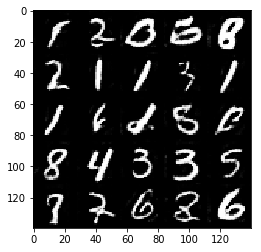

Epoch 2/2 ...  Discriminator Loss: 1.1106 Generator Loss: 0.9908
Epoch 2/2 ...  Discriminator Loss: 1.3488 Generator Loss: 0.6294
Epoch 2/2 ...  Discriminator Loss: 1.3537 Generator Loss: 0.5507
Epoch 2/2 ...  Discriminator Loss: 0.9604 Generator Loss: 1.0640
Epoch 2/2 ...  Discriminator Loss: 0.9449 Generator Loss: 0.8562
Epoch 2/2 ...  Discriminator Loss: 1.2714 Generator Loss: 0.7021
Epoch 2/2 ...  Discriminator Loss: 1.0401 Generator Loss: 0.9548
Epoch 2/2 ...  Discriminator Loss: 1.3521 Generator Loss: 1.3574
Epoch 2/2 ...  Discriminator Loss: 0.9187 Generator Loss: 0.9418
Epoch 2/2 ...  Discriminator Loss: 0.7841 Generator Loss: 1.4516


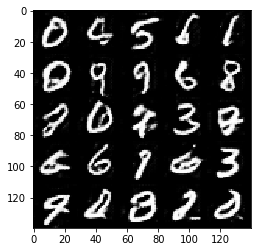

Epoch 2/2 ...  Discriminator Loss: 1.7386 Generator Loss: 2.3012
Epoch 2/2 ...  Discriminator Loss: 0.9983 Generator Loss: 0.9826
Epoch 2/2 ...  Discriminator Loss: 1.1285 Generator Loss: 0.7302
Epoch 2/2 ...  Discriminator Loss: 0.9137 Generator Loss: 1.0963
Epoch 2/2 ...  Discriminator Loss: 0.9854 Generator Loss: 0.8725
Epoch 2/2 ...  Discriminator Loss: 0.9509 Generator Loss: 1.0332
Epoch 2/2 ...  Discriminator Loss: 1.0437 Generator Loss: 1.4060
Epoch 2/2 ...  Discriminator Loss: 1.5426 Generator Loss: 0.5156
Epoch 2/2 ...  Discriminator Loss: 0.6817 Generator Loss: 1.5877
Epoch 2/2 ...  Discriminator Loss: 1.0853 Generator Loss: 1.9220


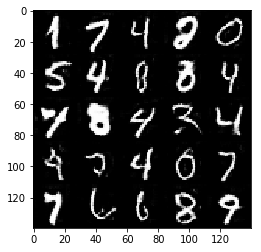

Epoch 2/2 ...  Discriminator Loss: 1.6304 Generator Loss: 0.4094
Epoch 2/2 ...  Discriminator Loss: 0.9468 Generator Loss: 1.2020
Epoch 2/2 ...  Discriminator Loss: 1.0131 Generator Loss: 0.8476
Epoch 2/2 ...  Discriminator Loss: 1.1624 Generator Loss: 1.4995
Epoch 2/2 ...  Discriminator Loss: 1.3857 Generator Loss: 0.4983
Epoch 2/2 ...  Discriminator Loss: 0.8011 Generator Loss: 1.0076
Epoch 2/2 ...  Discriminator Loss: 1.8425 Generator Loss: 0.3598
Epoch 2/2 ...  Discriminator Loss: 0.9283 Generator Loss: 0.9922
Epoch 2/2 ...  Discriminator Loss: 0.9609 Generator Loss: 0.9269
Epoch 2/2 ...  Discriminator Loss: 0.7668 Generator Loss: 1.0524


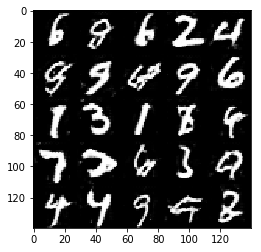

Epoch 2/2 ...  Discriminator Loss: 0.8678 Generator Loss: 1.2109
Epoch 2/2 ...  Discriminator Loss: 0.7193 Generator Loss: 1.6075
Epoch 2/2 ...  Discriminator Loss: 0.8938 Generator Loss: 1.1291
Epoch 2/2 ...  Discriminator Loss: 0.6342 Generator Loss: 1.2599
Epoch 2/2 ...  Discriminator Loss: 0.7955 Generator Loss: 1.1154
Epoch 2/2 ...  Discriminator Loss: 0.8271 Generator Loss: 1.2986
Epoch 2/2 ...  Discriminator Loss: 1.1425 Generator Loss: 0.7187
Epoch 2/2 ...  Discriminator Loss: 1.3402 Generator Loss: 0.5782
Epoch 2/2 ...  Discriminator Loss: 1.1413 Generator Loss: 0.7944
Epoch 2/2 ...  Discriminator Loss: 0.9506 Generator Loss: 1.2538


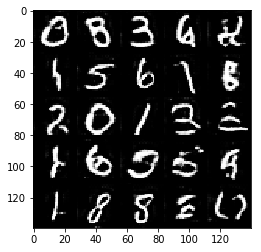

Epoch 2/2 ...  Discriminator Loss: 0.9240 Generator Loss: 1.4014
Epoch 2/2 ...  Discriminator Loss: 1.0801 Generator Loss: 0.8007
Epoch 2/2 ...  Discriminator Loss: 1.1084 Generator Loss: 0.6939
Epoch 2/2 ...  Discriminator Loss: 1.2599 Generator Loss: 0.5830
Epoch 2/2 ...  Discriminator Loss: 0.7348 Generator Loss: 1.2346
Epoch 2/2 ...  Discriminator Loss: 0.9391 Generator Loss: 0.8595
Epoch 2/2 ...  Discriminator Loss: 1.1107 Generator Loss: 1.6467
Epoch 2/2 ...  Discriminator Loss: 1.2459 Generator Loss: 0.6201
Epoch 2/2 ...  Discriminator Loss: 0.9307 Generator Loss: 0.8715
Epoch 2/2 ...  Discriminator Loss: 1.1714 Generator Loss: 0.7321


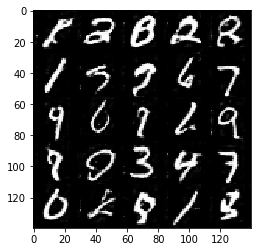

Epoch 2/2 ...  Discriminator Loss: 1.1177 Generator Loss: 0.7967
Epoch 2/2 ...  Discriminator Loss: 1.1082 Generator Loss: 1.3925
Epoch 2/2 ...  Discriminator Loss: 0.9058 Generator Loss: 1.2270
Epoch 2/2 ...  Discriminator Loss: 0.9988 Generator Loss: 1.1106
Epoch 2/2 ...  Discriminator Loss: 0.9929 Generator Loss: 0.8851
Epoch 2/2 ...  Discriminator Loss: 1.1847 Generator Loss: 0.6859
Epoch 2/2 ...  Discriminator Loss: 0.9036 Generator Loss: 1.9784
Epoch 2/2 ...  Discriminator Loss: 0.9432 Generator Loss: 0.8395
Epoch 2/2 ...  Discriminator Loss: 1.0269 Generator Loss: 0.7872
Epoch 2/2 ...  Discriminator Loss: 1.1880 Generator Loss: 0.6726


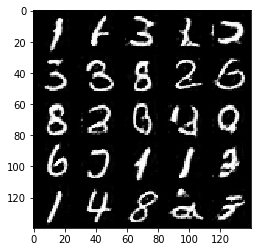

Epoch 2/2 ...  Discriminator Loss: 0.8759 Generator Loss: 1.4575
Epoch 2/2 ...  Discriminator Loss: 0.9052 Generator Loss: 0.8962
Epoch 2/2 ...  Discriminator Loss: 0.9180 Generator Loss: 1.1338
Epoch 2/2 ...  Discriminator Loss: 1.0964 Generator Loss: 0.9043
Epoch 2/2 ...  Discriminator Loss: 1.1797 Generator Loss: 0.6274
Epoch 2/2 ...  Discriminator Loss: 0.7437 Generator Loss: 1.3263
Epoch 2/2 ...  Discriminator Loss: 0.7858 Generator Loss: 1.0918
Epoch 2/2 ...  Discriminator Loss: 1.3165 Generator Loss: 1.1099
Epoch 2/2 ...  Discriminator Loss: 1.4133 Generator Loss: 0.4959
Epoch 2/2 ...  Discriminator Loss: 0.7322 Generator Loss: 1.1875


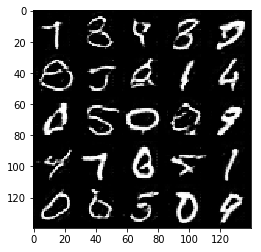

Epoch 2/2 ...  Discriminator Loss: 1.0274 Generator Loss: 0.9018
Epoch 2/2 ...  Discriminator Loss: 1.2222 Generator Loss: 0.5803
Epoch 2/2 ...  Discriminator Loss: 0.9635 Generator Loss: 0.8155
Epoch 2/2 ...  Discriminator Loss: 1.7652 Generator Loss: 0.3736
Epoch 2/2 ...  Discriminator Loss: 1.0163 Generator Loss: 0.8812
Epoch 2/2 ...  Discriminator Loss: 1.6412 Generator Loss: 2.3169
Epoch 2/2 ...  Discriminator Loss: 0.7302 Generator Loss: 1.2168
Epoch 2/2 ...  Discriminator Loss: 0.8244 Generator Loss: 1.4809
Epoch 2/2 ...  Discriminator Loss: 1.0718 Generator Loss: 0.7033
Epoch 2/2 ...  Discriminator Loss: 1.2050 Generator Loss: 0.6260


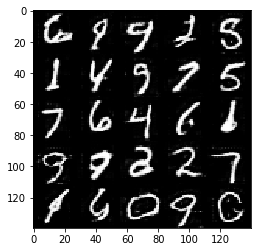

Epoch 2/2 ...  Discriminator Loss: 0.7810 Generator Loss: 1.4904
Epoch 2/2 ...  Discriminator Loss: 1.0010 Generator Loss: 0.7954
Epoch 2/2 ...  Discriminator Loss: 1.6627 Generator Loss: 0.4693
Epoch 2/2 ...  Discriminator Loss: 0.7720 Generator Loss: 1.3188
Epoch 2/2 ...  Discriminator Loss: 0.8051 Generator Loss: 1.1324
Epoch 2/2 ...  Discriminator Loss: 0.8602 Generator Loss: 0.9842
Epoch 2/2 ...  Discriminator Loss: 0.7908 Generator Loss: 1.7570
Epoch 2/2 ...  Discriminator Loss: 0.7505 Generator Loss: 1.2414
Epoch 2/2 ...  Discriminator Loss: 0.9228 Generator Loss: 1.1429
Epoch 2/2 ...  Discriminator Loss: 1.2894 Generator Loss: 0.7515


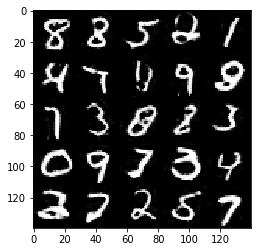

Epoch 2/2 ...  Discriminator Loss: 0.8863 Generator Loss: 1.1680
Epoch 2/2 ...  Discriminator Loss: 1.1000 Generator Loss: 0.8540
Epoch 2/2 ...  Discriminator Loss: 0.9030 Generator Loss: 0.9692
Epoch 2/2 ...  Discriminator Loss: 1.1160 Generator Loss: 0.6425
Epoch 2/2 ...  Discriminator Loss: 1.2147 Generator Loss: 0.5884
Epoch 2/2 ...  Discriminator Loss: 1.3339 Generator Loss: 0.6574
Epoch 2/2 ...  Discriminator Loss: 0.8831 Generator Loss: 1.1222
Epoch 2/2 ...  Discriminator Loss: 0.7953 Generator Loss: 1.1291
Epoch 2/2 ...  Discriminator Loss: 0.7372 Generator Loss: 1.6205
Epoch 2/2 ...  Discriminator Loss: 1.0647 Generator Loss: 0.7646


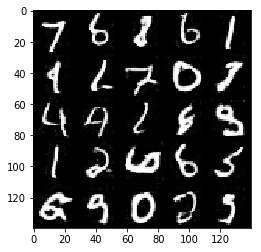

Epoch 2/2 ...  Discriminator Loss: 0.6872 Generator Loss: 1.4270
Epoch 2/2 ...  Discriminator Loss: 0.7718 Generator Loss: 1.5217
Epoch 2/2 ...  Discriminator Loss: 0.7680 Generator Loss: 1.1253
Epoch 2/2 ...  Discriminator Loss: 1.0016 Generator Loss: 0.7753
Epoch 2/2 ...  Discriminator Loss: 0.7246 Generator Loss: 1.1881
Epoch 2/2 ...  Discriminator Loss: 0.9768 Generator Loss: 2.0005
Epoch 2/2 ...  Discriminator Loss: 1.0582 Generator Loss: 1.0422
Epoch 2/2 ...  Discriminator Loss: 1.2335 Generator Loss: 0.6265
Epoch 2/2 ...  Discriminator Loss: 0.6577 Generator Loss: 1.4992
Epoch 2/2 ...  Discriminator Loss: 1.0646 Generator Loss: 0.7254


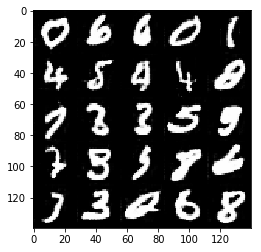

Epoch 2/2 ...  Discriminator Loss: 0.9100 Generator Loss: 1.2195
Epoch 2/2 ...  Discriminator Loss: 1.8416 Generator Loss: 0.3526
Epoch 2/2 ...  Discriminator Loss: 1.0073 Generator Loss: 0.8173
Epoch 2/2 ...  Discriminator Loss: 1.0571 Generator Loss: 0.6968
Epoch 2/2 ...  Discriminator Loss: 1.0751 Generator Loss: 0.7113
Epoch 2/2 ...  Discriminator Loss: 2.1329 Generator Loss: 0.3361
Epoch 2/2 ...  Discriminator Loss: 0.9218 Generator Loss: 0.9826
Epoch 2/2 ...  Discriminator Loss: 0.8837 Generator Loss: 1.6257
Epoch 2/2 ...  Discriminator Loss: 1.1862 Generator Loss: 0.7299
Epoch 2/2 ...  Discriminator Loss: 0.8871 Generator Loss: 0.9186


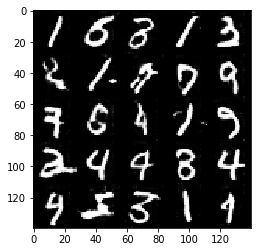

Epoch 2/2 ...  Discriminator Loss: 0.9848 Generator Loss: 0.8996
Epoch 2/2 ...  Discriminator Loss: 1.2695 Generator Loss: 0.5342
Epoch 2/2 ...  Discriminator Loss: 1.2969 Generator Loss: 0.5853
Epoch 2/2 ...  Discriminator Loss: 0.7362 Generator Loss: 1.2741
Epoch 2/2 ...  Discriminator Loss: 1.3524 Generator Loss: 0.5432
Epoch 2/2 ...  Discriminator Loss: 0.8288 Generator Loss: 1.2579
Epoch 2/2 ...  Discriminator Loss: 1.0736 Generator Loss: 0.8512
Epoch 2/2 ...  Discriminator Loss: 1.2286 Generator Loss: 1.2754
Epoch 2/2 ...  Discriminator Loss: 1.0893 Generator Loss: 0.6823
Epoch 2/2 ...  Discriminator Loss: 0.7799 Generator Loss: 1.3209


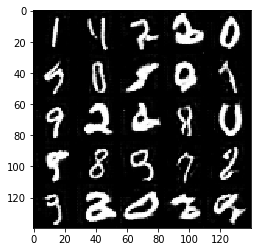

Epoch 2/2 ...  Discriminator Loss: 1.1335 Generator Loss: 0.6588
Epoch 2/2 ...  Discriminator Loss: 1.1830 Generator Loss: 0.7831
Epoch 2/2 ...  Discriminator Loss: 1.4041 Generator Loss: 0.5196
Epoch 2/2 ...  Discriminator Loss: 0.9307 Generator Loss: 1.1555
Epoch 2/2 ...  Discriminator Loss: 1.0011 Generator Loss: 0.9336
Epoch 2/2 ...  Discriminator Loss: 0.9468 Generator Loss: 0.9440
Epoch 2/2 ...  Discriminator Loss: 0.9055 Generator Loss: 0.9804
Epoch 2/2 ...  Discriminator Loss: 0.9606 Generator Loss: 1.3762
Epoch 2/2 ...  Discriminator Loss: 1.0612 Generator Loss: 0.7794
Epoch 2/2 ...  Discriminator Loss: 0.9644 Generator Loss: 0.9571


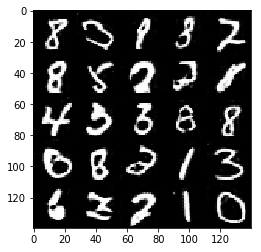

Epoch 2/2 ...  Discriminator Loss: 0.9378 Generator Loss: 1.0018
Epoch 2/2 ...  Discriminator Loss: 1.0715 Generator Loss: 0.9168
Epoch 2/2 ...  Discriminator Loss: 0.7665 Generator Loss: 1.3520
Epoch 2/2 ...  Discriminator Loss: 0.8220 Generator Loss: 1.4851
Epoch 2/2 ...  Discriminator Loss: 1.0129 Generator Loss: 1.5396
Epoch 2/2 ...  Discriminator Loss: 0.9509 Generator Loss: 1.4702
Epoch 2/2 ...  Discriminator Loss: 0.9601 Generator Loss: 1.0025
Epoch 2/2 ...  Discriminator Loss: 1.2295 Generator Loss: 0.5706
Epoch 2/2 ...  Discriminator Loss: 0.8477 Generator Loss: 1.2997
Epoch 2/2 ...  Discriminator Loss: 1.2444 Generator Loss: 0.5825


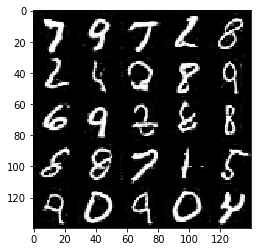

Epoch 2/2 ...  Discriminator Loss: 1.4271 Generator Loss: 0.5815
Epoch 2/2 ...  Discriminator Loss: 0.9411 Generator Loss: 0.9317
Epoch 2/2 ...  Discriminator Loss: 1.1834 Generator Loss: 0.6747
Epoch 2/2 ...  Discriminator Loss: 1.0195 Generator Loss: 1.0315
Epoch 2/2 ...  Discriminator Loss: 1.1591 Generator Loss: 0.6518
Epoch 2/2 ...  Discriminator Loss: 1.0539 Generator Loss: 0.7521
Epoch 2/2 ...  Discriminator Loss: 0.8132 Generator Loss: 1.0479
Epoch 2/2 ...  Discriminator Loss: 1.0076 Generator Loss: 0.7895
Epoch 2/2 ...  Discriminator Loss: 0.9524 Generator Loss: 1.3426
Epoch 2/2 ...  Discriminator Loss: 1.1159 Generator Loss: 0.8885


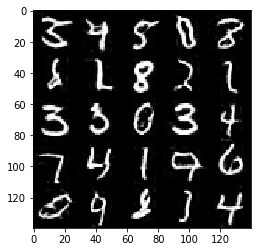

Epoch 2/2 ...  Discriminator Loss: 0.9247 Generator Loss: 1.1478
Epoch 2/2 ...  Discriminator Loss: 0.7591 Generator Loss: 1.4913
Epoch 2/2 ...  Discriminator Loss: 1.0264 Generator Loss: 1.1186
Epoch 2/2 ...  Discriminator Loss: 0.9209 Generator Loss: 0.8714
Epoch 2/2 ...  Discriminator Loss: 0.9211 Generator Loss: 0.9692
Epoch 2/2 ...  Discriminator Loss: 0.9740 Generator Loss: 0.9205
Epoch 2/2 ...  Discriminator Loss: 1.1837 Generator Loss: 0.6424
Epoch 2/2 ...  Discriminator Loss: 0.7078 Generator Loss: 1.2340
Epoch 2/2 ...  Discriminator Loss: 0.9000 Generator Loss: 0.8409
Epoch 2/2 ...  Discriminator Loss: 0.9317 Generator Loss: 0.8914


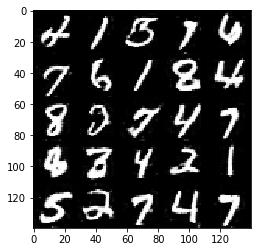

Epoch 2/2 ...  Discriminator Loss: 0.6293 Generator Loss: 1.2569
Epoch 2/2 ...  Discriminator Loss: 1.0528 Generator Loss: 1.0215
Epoch 2/2 ...  Discriminator Loss: 0.7846 Generator Loss: 1.1536
Epoch 2/2 ...  Discriminator Loss: 1.5911 Generator Loss: 0.4143
Epoch 2/2 ...  Discriminator Loss: 1.1231 Generator Loss: 0.7316
Epoch 2/2 ...  Discriminator Loss: 1.0199 Generator Loss: 0.7100
Epoch 2/2 ...  Discriminator Loss: 1.1290 Generator Loss: 0.6543
Epoch 2/2 ...  Discriminator Loss: 1.0463 Generator Loss: 0.7770
Epoch 2/2 ...  Discriminator Loss: 0.8133 Generator Loss: 1.0734
Epoch 2/2 ...  Discriminator Loss: 1.1976 Generator Loss: 0.6042


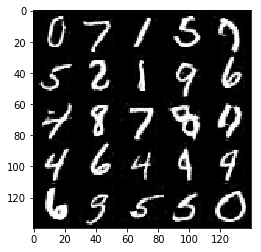

Epoch 2/2 ...  Discriminator Loss: 0.6111 Generator Loss: 1.4992
Epoch 2/2 ...  Discriminator Loss: 1.0087 Generator Loss: 0.8706
Epoch 2/2 ...  Discriminator Loss: 0.9901 Generator Loss: 1.1679
Epoch 2/2 ...  Discriminator Loss: 0.9510 Generator Loss: 0.9756
Epoch 2/2 ...  Discriminator Loss: 1.0277 Generator Loss: 0.9649


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ...  Discriminator Loss: 0.2582 Generator Loss: 6.0407
Epoch 1/1 ...  Discriminator Loss: 0.3317 Generator Loss: 4.0262
Epoch 1/1 ...  Discriminator Loss: 1.6148 Generator Loss: 3.4518
Epoch 1/1 ...  Discriminator Loss: 1.6137 Generator Loss: 1.6966
Epoch 1/1 ...  Discriminator Loss: 1.2824 Generator Loss: 1.1274
Epoch 1/1 ...  Discriminator Loss: 1.7019 Generator Loss: 0.8124
Epoch 1/1 ...  Discriminator Loss: 1.3598 Generator Loss: 0.7830
Epoch 1/1 ...  Discriminator Loss: 1.3711 Generator Loss: 0.5726
Epoch 1/1 ...  Discriminator Loss: 0.7405 Generator Loss: 2.4392
Epoch 1/1 ...  Discriminator Loss: 1.2910 Generator Loss: 1.3957


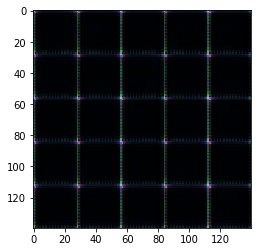

Epoch 1/1 ...  Discriminator Loss: 1.5638 Generator Loss: 0.4581
Epoch 1/1 ...  Discriminator Loss: 0.9858 Generator Loss: 1.2780
Epoch 1/1 ...  Discriminator Loss: 1.5777 Generator Loss: 1.9172
Epoch 1/1 ...  Discriminator Loss: 1.0539 Generator Loss: 1.1169
Epoch 1/1 ...  Discriminator Loss: 1.8213 Generator Loss: 1.5338
Epoch 1/1 ...  Discriminator Loss: 1.5154 Generator Loss: 0.5535
Epoch 1/1 ...  Discriminator Loss: 1.1559 Generator Loss: 0.6897
Epoch 1/1 ...  Discriminator Loss: 1.4058 Generator Loss: 0.5555
Epoch 1/1 ...  Discriminator Loss: 1.3660 Generator Loss: 0.8480
Epoch 1/1 ...  Discriminator Loss: 2.0353 Generator Loss: 0.3923


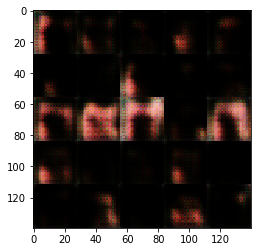

Epoch 1/1 ...  Discriminator Loss: 1.2524 Generator Loss: 1.6089
Epoch 1/1 ...  Discriminator Loss: 1.1096 Generator Loss: 0.9519
Epoch 1/1 ...  Discriminator Loss: 1.3188 Generator Loss: 0.5877
Epoch 1/1 ...  Discriminator Loss: 1.1144 Generator Loss: 0.9724
Epoch 1/1 ...  Discriminator Loss: 1.2051 Generator Loss: 1.4001
Epoch 1/1 ...  Discriminator Loss: 1.5457 Generator Loss: 0.4879
Epoch 1/1 ...  Discriminator Loss: 1.7557 Generator Loss: 0.4584
Epoch 1/1 ...  Discriminator Loss: 1.5012 Generator Loss: 2.9364
Epoch 1/1 ...  Discriminator Loss: 0.9868 Generator Loss: 1.8349
Epoch 1/1 ...  Discriminator Loss: 1.0623 Generator Loss: 1.2185


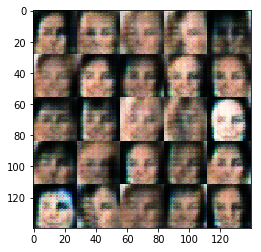

Epoch 1/1 ...  Discriminator Loss: 1.3059 Generator Loss: 2.8233
Epoch 1/1 ...  Discriminator Loss: 1.6945 Generator Loss: 2.5784
Epoch 1/1 ...  Discriminator Loss: 1.1980 Generator Loss: 1.6562
Epoch 1/1 ...  Discriminator Loss: 1.0112 Generator Loss: 0.8528
Epoch 1/1 ...  Discriminator Loss: 0.9629 Generator Loss: 1.5139
Epoch 1/1 ...  Discriminator Loss: 1.3941 Generator Loss: 0.5467
Epoch 1/1 ...  Discriminator Loss: 1.0039 Generator Loss: 1.6169
Epoch 1/1 ...  Discriminator Loss: 1.6335 Generator Loss: 0.4701
Epoch 1/1 ...  Discriminator Loss: 1.3824 Generator Loss: 0.9786
Epoch 1/1 ...  Discriminator Loss: 1.6583 Generator Loss: 0.4111


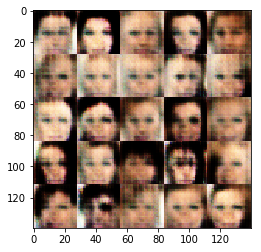

Epoch 1/1 ...  Discriminator Loss: 0.9193 Generator Loss: 0.8416
Epoch 1/1 ...  Discriminator Loss: 2.0927 Generator Loss: 0.2802
Epoch 1/1 ...  Discriminator Loss: 1.2482 Generator Loss: 0.7069
Epoch 1/1 ...  Discriminator Loss: 1.2361 Generator Loss: 1.6474
Epoch 1/1 ...  Discriminator Loss: 1.2123 Generator Loss: 0.7315
Epoch 1/1 ...  Discriminator Loss: 2.4893 Generator Loss: 0.2356
Epoch 1/1 ...  Discriminator Loss: 1.6867 Generator Loss: 0.8688
Epoch 1/1 ...  Discriminator Loss: 1.1058 Generator Loss: 0.9979
Epoch 1/1 ...  Discriminator Loss: 1.7874 Generator Loss: 0.3834
Epoch 1/1 ...  Discriminator Loss: 1.2835 Generator Loss: 0.6507


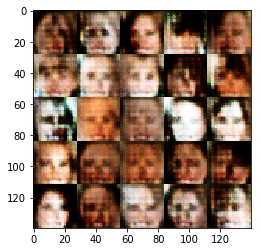

Epoch 1/1 ...  Discriminator Loss: 2.0964 Generator Loss: 0.2869
Epoch 1/1 ...  Discriminator Loss: 1.1273 Generator Loss: 0.7790
Epoch 1/1 ...  Discriminator Loss: 1.4094 Generator Loss: 0.5583
Epoch 1/1 ...  Discriminator Loss: 1.1284 Generator Loss: 1.0333
Epoch 1/1 ...  Discriminator Loss: 1.4460 Generator Loss: 1.4357
Epoch 1/1 ...  Discriminator Loss: 1.0165 Generator Loss: 1.0716
Epoch 1/1 ...  Discriminator Loss: 1.3667 Generator Loss: 0.5720
Epoch 1/1 ...  Discriminator Loss: 0.9628 Generator Loss: 0.9796
Epoch 1/1 ...  Discriminator Loss: 1.4775 Generator Loss: 0.4404
Epoch 1/1 ...  Discriminator Loss: 0.8942 Generator Loss: 0.9514


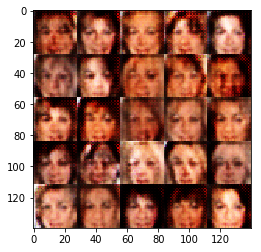

Epoch 1/1 ...  Discriminator Loss: 0.9784 Generator Loss: 2.5408
Epoch 1/1 ...  Discriminator Loss: 1.3377 Generator Loss: 1.4695
Epoch 1/1 ...  Discriminator Loss: 1.4580 Generator Loss: 0.4862
Epoch 1/1 ...  Discriminator Loss: 1.7322 Generator Loss: 2.1055
Epoch 1/1 ...  Discriminator Loss: 1.2924 Generator Loss: 1.1097
Epoch 1/1 ...  Discriminator Loss: 1.3241 Generator Loss: 0.6137
Epoch 1/1 ...  Discriminator Loss: 0.9219 Generator Loss: 0.8937
Epoch 1/1 ...  Discriminator Loss: 1.3035 Generator Loss: 0.6465
Epoch 1/1 ...  Discriminator Loss: 0.9861 Generator Loss: 1.2648
Epoch 1/1 ...  Discriminator Loss: 1.0921 Generator Loss: 1.3018


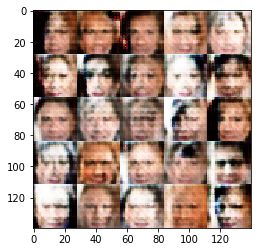

Epoch 1/1 ...  Discriminator Loss: 1.6284 Generator Loss: 0.6341
Epoch 1/1 ...  Discriminator Loss: 1.1285 Generator Loss: 0.9655
Epoch 1/1 ...  Discriminator Loss: 1.1259 Generator Loss: 1.2258
Epoch 1/1 ...  Discriminator Loss: 0.5722 Generator Loss: 1.5835
Epoch 1/1 ...  Discriminator Loss: 1.3487 Generator Loss: 0.5035
Epoch 1/1 ...  Discriminator Loss: 1.7666 Generator Loss: 1.2718
Epoch 1/1 ...  Discriminator Loss: 0.7394 Generator Loss: 1.3866
Epoch 1/1 ...  Discriminator Loss: 1.2389 Generator Loss: 0.7638
Epoch 1/1 ...  Discriminator Loss: 1.0300 Generator Loss: 0.8255
Epoch 1/1 ...  Discriminator Loss: 1.3240 Generator Loss: 1.7558


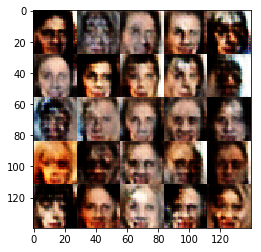

Epoch 1/1 ...  Discriminator Loss: 1.5186 Generator Loss: 1.0814
Epoch 1/1 ...  Discriminator Loss: 1.1472 Generator Loss: 0.6868
Epoch 1/1 ...  Discriminator Loss: 1.4148 Generator Loss: 0.5382
Epoch 1/1 ...  Discriminator Loss: 1.2496 Generator Loss: 0.6682
Epoch 1/1 ...  Discriminator Loss: 1.2015 Generator Loss: 0.6401
Epoch 1/1 ...  Discriminator Loss: 1.6926 Generator Loss: 0.3879
Epoch 1/1 ...  Discriminator Loss: 1.1525 Generator Loss: 1.0151
Epoch 1/1 ...  Discriminator Loss: 1.5538 Generator Loss: 0.5074
Epoch 1/1 ...  Discriminator Loss: 1.1709 Generator Loss: 0.9129
Epoch 1/1 ...  Discriminator Loss: 1.7752 Generator Loss: 0.3685


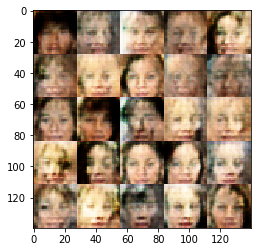

Epoch 1/1 ...  Discriminator Loss: 1.3499 Generator Loss: 0.5236
Epoch 1/1 ...  Discriminator Loss: 1.0882 Generator Loss: 0.7079
Epoch 1/1 ...  Discriminator Loss: 1.3248 Generator Loss: 1.7411
Epoch 1/1 ...  Discriminator Loss: 1.4758 Generator Loss: 0.4462
Epoch 1/1 ...  Discriminator Loss: 1.0046 Generator Loss: 0.8593
Epoch 1/1 ...  Discriminator Loss: 1.0677 Generator Loss: 0.8018
Epoch 1/1 ...  Discriminator Loss: 1.5176 Generator Loss: 0.5382
Epoch 1/1 ...  Discriminator Loss: 1.1755 Generator Loss: 1.3020
Epoch 1/1 ...  Discriminator Loss: 1.2500 Generator Loss: 0.6289
Epoch 1/1 ...  Discriminator Loss: 1.3089 Generator Loss: 0.6248


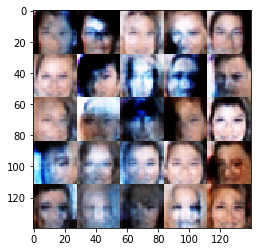

Epoch 1/1 ...  Discriminator Loss: 3.2394 Generator Loss: 4.1517
Epoch 1/1 ...  Discriminator Loss: 1.2717 Generator Loss: 0.6425
Epoch 1/1 ...  Discriminator Loss: 1.4901 Generator Loss: 0.5249
Epoch 1/1 ...  Discriminator Loss: 1.7340 Generator Loss: 0.3803
Epoch 1/1 ...  Discriminator Loss: 0.8875 Generator Loss: 0.8871
Epoch 1/1 ...  Discriminator Loss: 1.4044 Generator Loss: 0.9792
Epoch 1/1 ...  Discriminator Loss: 1.4560 Generator Loss: 0.7809
Epoch 1/1 ...  Discriminator Loss: 1.2609 Generator Loss: 0.6807
Epoch 1/1 ...  Discriminator Loss: 1.4295 Generator Loss: 0.5950
Epoch 1/1 ...  Discriminator Loss: 1.3874 Generator Loss: 0.8455


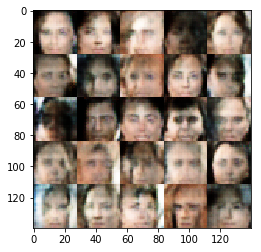

Epoch 1/1 ...  Discriminator Loss: 1.1854 Generator Loss: 0.8354
Epoch 1/1 ...  Discriminator Loss: 1.3336 Generator Loss: 0.7741
Epoch 1/1 ...  Discriminator Loss: 1.0895 Generator Loss: 1.4142
Epoch 1/1 ...  Discriminator Loss: 1.4699 Generator Loss: 0.4941
Epoch 1/1 ...  Discriminator Loss: 1.4447 Generator Loss: 0.5020
Epoch 1/1 ...  Discriminator Loss: 1.2809 Generator Loss: 0.6457
Epoch 1/1 ...  Discriminator Loss: 1.0945 Generator Loss: 0.8175
Epoch 1/1 ...  Discriminator Loss: 1.6245 Generator Loss: 0.3890
Epoch 1/1 ...  Discriminator Loss: 1.2591 Generator Loss: 0.7524
Epoch 1/1 ...  Discriminator Loss: 1.2384 Generator Loss: 0.6653


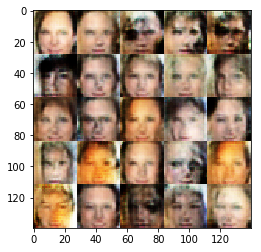

Epoch 1/1 ...  Discriminator Loss: 1.4760 Generator Loss: 0.4611
Epoch 1/1 ...  Discriminator Loss: 1.4177 Generator Loss: 0.6373
Epoch 1/1 ...  Discriminator Loss: 1.2197 Generator Loss: 0.7384
Epoch 1/1 ...  Discriminator Loss: 1.3822 Generator Loss: 0.4930
Epoch 1/1 ...  Discriminator Loss: 1.5841 Generator Loss: 0.4364
Epoch 1/1 ...  Discriminator Loss: 1.0247 Generator Loss: 0.8094
Epoch 1/1 ...  Discriminator Loss: 1.2067 Generator Loss: 0.6545
Epoch 1/1 ...  Discriminator Loss: 1.3406 Generator Loss: 1.7392
Epoch 1/1 ...  Discriminator Loss: 1.4210 Generator Loss: 0.5073
Epoch 1/1 ...  Discriminator Loss: 1.0773 Generator Loss: 0.8916


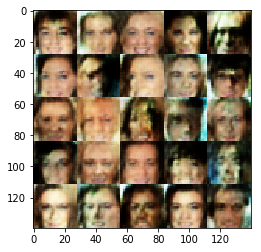

Epoch 1/1 ...  Discriminator Loss: 1.1537 Generator Loss: 0.7092
Epoch 1/1 ...  Discriminator Loss: 1.1385 Generator Loss: 0.9896
Epoch 1/1 ...  Discriminator Loss: 1.3025 Generator Loss: 0.5540
Epoch 1/1 ...  Discriminator Loss: 1.4365 Generator Loss: 0.4817
Epoch 1/1 ...  Discriminator Loss: 1.3458 Generator Loss: 0.6136
Epoch 1/1 ...  Discriminator Loss: 1.1580 Generator Loss: 1.0593
Epoch 1/1 ...  Discriminator Loss: 1.4555 Generator Loss: 0.6157
Epoch 1/1 ...  Discriminator Loss: 1.2531 Generator Loss: 0.9588
Epoch 1/1 ...  Discriminator Loss: 1.2638 Generator Loss: 0.7426
Epoch 1/1 ...  Discriminator Loss: 1.3451 Generator Loss: 0.6398


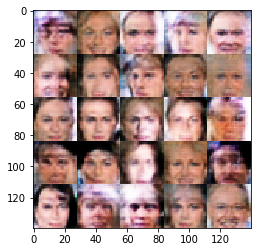

Epoch 1/1 ...  Discriminator Loss: 1.1909 Generator Loss: 0.7326
Epoch 1/1 ...  Discriminator Loss: 1.1284 Generator Loss: 1.0780
Epoch 1/1 ...  Discriminator Loss: 1.3673 Generator Loss: 0.4965
Epoch 1/1 ...  Discriminator Loss: 1.2648 Generator Loss: 1.0392
Epoch 1/1 ...  Discriminator Loss: 1.4139 Generator Loss: 0.5609
Epoch 1/1 ...  Discriminator Loss: 1.2017 Generator Loss: 0.7421
Epoch 1/1 ...  Discriminator Loss: 1.4862 Generator Loss: 0.4933
Epoch 1/1 ...  Discriminator Loss: 1.7738 Generator Loss: 0.3395
Epoch 1/1 ...  Discriminator Loss: 0.6930 Generator Loss: 1.4334
Epoch 1/1 ...  Discriminator Loss: 1.2867 Generator Loss: 0.6147


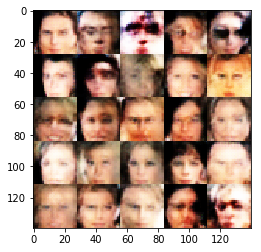

Epoch 1/1 ...  Discriminator Loss: 1.4277 Generator Loss: 0.4833
Epoch 1/1 ...  Discriminator Loss: 1.2884 Generator Loss: 0.6580
Epoch 1/1 ...  Discriminator Loss: 1.6620 Generator Loss: 0.4022
Epoch 1/1 ...  Discriminator Loss: 1.3461 Generator Loss: 0.5296
Epoch 1/1 ...  Discriminator Loss: 1.1698 Generator Loss: 0.7603
Epoch 1/1 ...  Discriminator Loss: 1.3543 Generator Loss: 0.8749
Epoch 1/1 ...  Discriminator Loss: 1.1262 Generator Loss: 0.9294
Epoch 1/1 ...  Discriminator Loss: 1.4951 Generator Loss: 0.4738
Epoch 1/1 ...  Discriminator Loss: 1.3233 Generator Loss: 0.5730
Epoch 1/1 ...  Discriminator Loss: 1.6114 Generator Loss: 0.5481


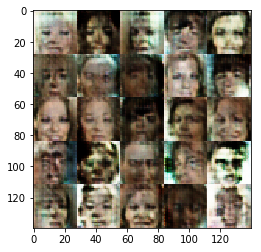

Epoch 1/1 ...  Discriminator Loss: 1.5544 Generator Loss: 0.4257
Epoch 1/1 ...  Discriminator Loss: 1.3135 Generator Loss: 0.8600
Epoch 1/1 ...  Discriminator Loss: 1.4699 Generator Loss: 0.5225
Epoch 1/1 ...  Discriminator Loss: 1.0485 Generator Loss: 0.9642
Epoch 1/1 ...  Discriminator Loss: 1.3936 Generator Loss: 0.7707
Epoch 1/1 ...  Discriminator Loss: 1.0920 Generator Loss: 0.6752
Epoch 1/1 ...  Discriminator Loss: 1.2841 Generator Loss: 0.7726
Epoch 1/1 ...  Discriminator Loss: 1.4142 Generator Loss: 1.3332
Epoch 1/1 ...  Discriminator Loss: 1.6532 Generator Loss: 0.4002
Epoch 1/1 ...  Discriminator Loss: 1.4687 Generator Loss: 0.5968


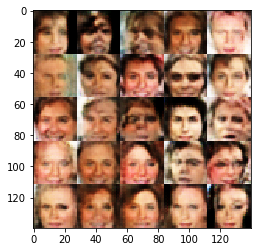

Epoch 1/1 ...  Discriminator Loss: 1.1455 Generator Loss: 1.0976
Epoch 1/1 ...  Discriminator Loss: 1.3452 Generator Loss: 1.1038
Epoch 1/1 ...  Discriminator Loss: 1.3052 Generator Loss: 0.5735
Epoch 1/1 ...  Discriminator Loss: 1.3362 Generator Loss: 0.6269
Epoch 1/1 ...  Discriminator Loss: 1.3616 Generator Loss: 0.6754
Epoch 1/1 ...  Discriminator Loss: 1.5868 Generator Loss: 0.6576
Epoch 1/1 ...  Discriminator Loss: 1.1913 Generator Loss: 0.6614
Epoch 1/1 ...  Discriminator Loss: 1.2878 Generator Loss: 0.5586
Epoch 1/1 ...  Discriminator Loss: 1.4143 Generator Loss: 0.5047
Epoch 1/1 ...  Discriminator Loss: 1.7115 Generator Loss: 0.9635


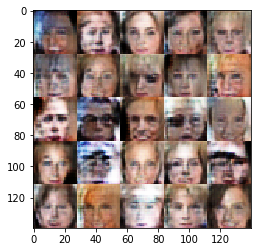

Epoch 1/1 ...  Discriminator Loss: 1.3250 Generator Loss: 0.5874
Epoch 1/1 ...  Discriminator Loss: 1.2131 Generator Loss: 0.8277
Epoch 1/1 ...  Discriminator Loss: 1.2031 Generator Loss: 0.7473
Epoch 1/1 ...  Discriminator Loss: 1.2986 Generator Loss: 0.7732
Epoch 1/1 ...  Discriminator Loss: 1.2583 Generator Loss: 0.7730
Epoch 1/1 ...  Discriminator Loss: 0.8967 Generator Loss: 1.2133
Epoch 1/1 ...  Discriminator Loss: 0.7843 Generator Loss: 1.0728
Epoch 1/1 ...  Discriminator Loss: 1.0240 Generator Loss: 0.8602
Epoch 1/1 ...  Discriminator Loss: 1.3020 Generator Loss: 0.6223
Epoch 1/1 ...  Discriminator Loss: 1.3238 Generator Loss: 0.7367


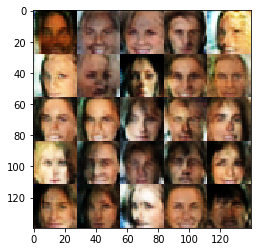

Epoch 1/1 ...  Discriminator Loss: 1.7841 Generator Loss: 0.3525
Epoch 1/1 ...  Discriminator Loss: 1.2951 Generator Loss: 0.7364
Epoch 1/1 ...  Discriminator Loss: 1.0603 Generator Loss: 0.8168
Epoch 1/1 ...  Discriminator Loss: 1.1727 Generator Loss: 1.1044
Epoch 1/1 ...  Discriminator Loss: 1.4138 Generator Loss: 0.6199
Epoch 1/1 ...  Discriminator Loss: 1.3407 Generator Loss: 0.8282
Epoch 1/1 ...  Discriminator Loss: 1.2667 Generator Loss: 0.7562
Epoch 1/1 ...  Discriminator Loss: 1.5953 Generator Loss: 0.4562
Epoch 1/1 ...  Discriminator Loss: 1.0424 Generator Loss: 1.5827
Epoch 1/1 ...  Discriminator Loss: 1.2821 Generator Loss: 0.6169


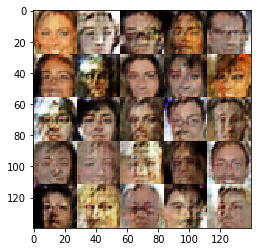

Epoch 1/1 ...  Discriminator Loss: 0.8967 Generator Loss: 1.1201
Epoch 1/1 ...  Discriminator Loss: 1.6360 Generator Loss: 0.4530
Epoch 1/1 ...  Discriminator Loss: 1.2312 Generator Loss: 0.7940
Epoch 1/1 ...  Discriminator Loss: 1.5159 Generator Loss: 0.5041
Epoch 1/1 ...  Discriminator Loss: 1.4570 Generator Loss: 0.5760
Epoch 1/1 ...  Discriminator Loss: 1.2848 Generator Loss: 0.8153
Epoch 1/1 ...  Discriminator Loss: 0.8878 Generator Loss: 1.2087
Epoch 1/1 ...  Discriminator Loss: 1.3635 Generator Loss: 0.5187
Epoch 1/1 ...  Discriminator Loss: 1.5011 Generator Loss: 0.6135
Epoch 1/1 ...  Discriminator Loss: 1.5603 Generator Loss: 0.4850


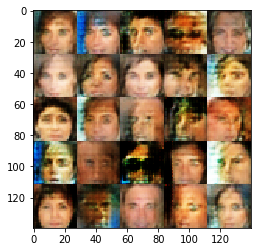

Epoch 1/1 ...  Discriminator Loss: 1.2547 Generator Loss: 1.0015
Epoch 1/1 ...  Discriminator Loss: 2.1552 Generator Loss: 0.2773
Epoch 1/1 ...  Discriminator Loss: 1.1427 Generator Loss: 0.7836
Epoch 1/1 ...  Discriminator Loss: 1.1160 Generator Loss: 0.7215
Epoch 1/1 ...  Discriminator Loss: 1.1971 Generator Loss: 0.8578
Epoch 1/1 ...  Discriminator Loss: 1.5612 Generator Loss: 0.4276
Epoch 1/1 ...  Discriminator Loss: 1.2923 Generator Loss: 0.7079
Epoch 1/1 ...  Discriminator Loss: 1.3277 Generator Loss: 0.7695
Epoch 1/1 ...  Discriminator Loss: 1.4150 Generator Loss: 0.5770
Epoch 1/1 ...  Discriminator Loss: 1.4076 Generator Loss: 0.5657


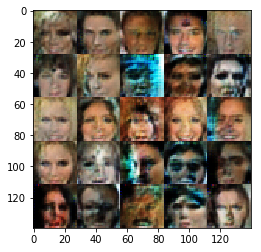

Epoch 1/1 ...  Discriminator Loss: 1.4334 Generator Loss: 0.6822
Epoch 1/1 ...  Discriminator Loss: 1.6230 Generator Loss: 0.4109
Epoch 1/1 ...  Discriminator Loss: 1.2315 Generator Loss: 0.5552
Epoch 1/1 ...  Discriminator Loss: 1.2949 Generator Loss: 0.7988
Epoch 1/1 ...  Discriminator Loss: 1.5744 Generator Loss: 0.6231
Epoch 1/1 ...  Discriminator Loss: 1.2446 Generator Loss: 0.7293
Epoch 1/1 ...  Discriminator Loss: 1.1706 Generator Loss: 0.8392
Epoch 1/1 ...  Discriminator Loss: 1.4919 Generator Loss: 0.4754
Epoch 1/1 ...  Discriminator Loss: 1.4142 Generator Loss: 0.5171
Epoch 1/1 ...  Discriminator Loss: 1.1296 Generator Loss: 0.6480


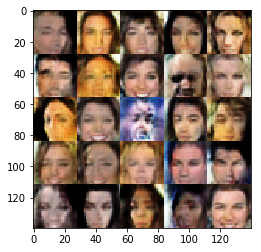

Epoch 1/1 ...  Discriminator Loss: 1.4206 Generator Loss: 0.9390
Epoch 1/1 ...  Discriminator Loss: 1.3518 Generator Loss: 0.6909
Epoch 1/1 ...  Discriminator Loss: 1.3504 Generator Loss: 0.4934
Epoch 1/1 ...  Discriminator Loss: 1.4638 Generator Loss: 0.5788
Epoch 1/1 ...  Discriminator Loss: 1.3896 Generator Loss: 0.8817
Epoch 1/1 ...  Discriminator Loss: 0.6961 Generator Loss: 1.1071
Epoch 1/1 ...  Discriminator Loss: 1.1453 Generator Loss: 0.7306
Epoch 1/1 ...  Discriminator Loss: 1.2273 Generator Loss: 0.8143
Epoch 1/1 ...  Discriminator Loss: 1.3452 Generator Loss: 0.6371
Epoch 1/1 ...  Discriminator Loss: 1.4130 Generator Loss: 0.5918


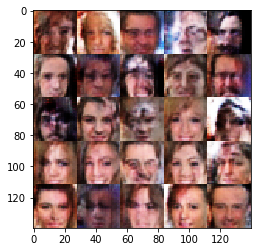

Epoch 1/1 ...  Discriminator Loss: 1.2781 Generator Loss: 0.6536
Epoch 1/1 ...  Discriminator Loss: 1.3196 Generator Loss: 0.5102
Epoch 1/1 ...  Discriminator Loss: 1.5623 Generator Loss: 0.5225
Epoch 1/1 ...  Discriminator Loss: 1.4826 Generator Loss: 0.5671
Epoch 1/1 ...  Discriminator Loss: 1.2665 Generator Loss: 0.6989
Epoch 1/1 ...  Discriminator Loss: 1.1884 Generator Loss: 1.2144
Epoch 1/1 ...  Discriminator Loss: 1.2761 Generator Loss: 0.9800
Epoch 1/1 ...  Discriminator Loss: 1.4238 Generator Loss: 0.9833
Epoch 1/1 ...  Discriminator Loss: 1.1898 Generator Loss: 0.8467
Epoch 1/1 ...  Discriminator Loss: 1.3565 Generator Loss: 0.6030


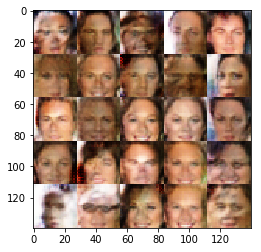

Epoch 1/1 ...  Discriminator Loss: 1.1290 Generator Loss: 0.8496
Epoch 1/1 ...  Discriminator Loss: 1.3844 Generator Loss: 0.6710
Epoch 1/1 ...  Discriminator Loss: 1.5429 Generator Loss: 0.5006
Epoch 1/1 ...  Discriminator Loss: 1.4688 Generator Loss: 0.5680
Epoch 1/1 ...  Discriminator Loss: 1.0479 Generator Loss: 0.9238
Epoch 1/1 ...  Discriminator Loss: 1.2563 Generator Loss: 0.6390
Epoch 1/1 ...  Discriminator Loss: 1.3533 Generator Loss: 0.6354
Epoch 1/1 ...  Discriminator Loss: 1.3156 Generator Loss: 0.7919
Epoch 1/1 ...  Discriminator Loss: 1.4943 Generator Loss: 2.0681
Epoch 1/1 ...  Discriminator Loss: 1.4289 Generator Loss: 0.5380


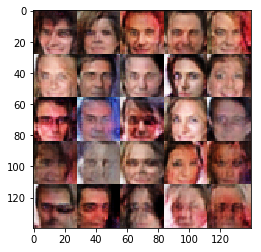

Epoch 1/1 ...  Discriminator Loss: 1.4043 Generator Loss: 0.6104
Epoch 1/1 ...  Discriminator Loss: 1.4149 Generator Loss: 0.5851
Epoch 1/1 ...  Discriminator Loss: 1.0859 Generator Loss: 0.9654
Epoch 1/1 ...  Discriminator Loss: 1.3349 Generator Loss: 0.6049
Epoch 1/1 ...  Discriminator Loss: 1.4212 Generator Loss: 0.5919
Epoch 1/1 ...  Discriminator Loss: 1.1737 Generator Loss: 0.6335
Epoch 1/1 ...  Discriminator Loss: 1.5602 Generator Loss: 1.5228
Epoch 1/1 ...  Discriminator Loss: 1.3478 Generator Loss: 0.6449
Epoch 1/1 ...  Discriminator Loss: 1.4454 Generator Loss: 0.5324
Epoch 1/1 ...  Discriminator Loss: 1.6167 Generator Loss: 0.4060


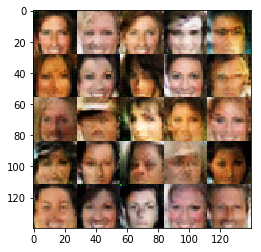

Epoch 1/1 ...  Discriminator Loss: 1.2730 Generator Loss: 0.6082
Epoch 1/1 ...  Discriminator Loss: 1.2872 Generator Loss: 0.7213
Epoch 1/1 ...  Discriminator Loss: 1.0902 Generator Loss: 1.1633
Epoch 1/1 ...  Discriminator Loss: 1.0139 Generator Loss: 0.7026
Epoch 1/1 ...  Discriminator Loss: 1.2733 Generator Loss: 0.8074
Epoch 1/1 ...  Discriminator Loss: 1.4899 Generator Loss: 0.6765
Epoch 1/1 ...  Discriminator Loss: 1.4125 Generator Loss: 0.6847
Epoch 1/1 ...  Discriminator Loss: 1.3304 Generator Loss: 0.5951
Epoch 1/1 ...  Discriminator Loss: 1.4215 Generator Loss: 0.5963
Epoch 1/1 ...  Discriminator Loss: 1.3450 Generator Loss: 0.7593


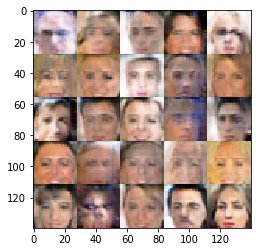

Epoch 1/1 ...  Discriminator Loss: 1.3243 Generator Loss: 0.7545
Epoch 1/1 ...  Discriminator Loss: 1.1891 Generator Loss: 0.5968
Epoch 1/1 ...  Discriminator Loss: 1.5267 Generator Loss: 0.7161
Epoch 1/1 ...  Discriminator Loss: 1.4210 Generator Loss: 0.5683
Epoch 1/1 ...  Discriminator Loss: 1.2630 Generator Loss: 0.7901
Epoch 1/1 ...  Discriminator Loss: 1.3187 Generator Loss: 1.0747
Epoch 1/1 ...  Discriminator Loss: 1.3179 Generator Loss: 1.0792
Epoch 1/1 ...  Discriminator Loss: 1.3295 Generator Loss: 0.7710
Epoch 1/1 ...  Discriminator Loss: 1.4456 Generator Loss: 0.6825
Epoch 1/1 ...  Discriminator Loss: 1.3467 Generator Loss: 0.6712


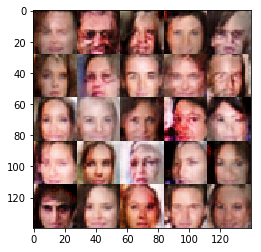

Epoch 1/1 ...  Discriminator Loss: 1.4732 Generator Loss: 0.5845
Epoch 1/1 ...  Discriminator Loss: 1.3777 Generator Loss: 0.6009
Epoch 1/1 ...  Discriminator Loss: 1.1415 Generator Loss: 1.0294
Epoch 1/1 ...  Discriminator Loss: 1.4273 Generator Loss: 0.6806
Epoch 1/1 ...  Discriminator Loss: 1.4567 Generator Loss: 0.6241
Epoch 1/1 ...  Discriminator Loss: 1.3983 Generator Loss: 0.6893
Epoch 1/1 ...  Discriminator Loss: 1.4381 Generator Loss: 0.5507
Epoch 1/1 ...  Discriminator Loss: 1.1327 Generator Loss: 0.8626
Epoch 1/1 ...  Discriminator Loss: 1.2610 Generator Loss: 0.6928
Epoch 1/1 ...  Discriminator Loss: 1.3706 Generator Loss: 1.0654


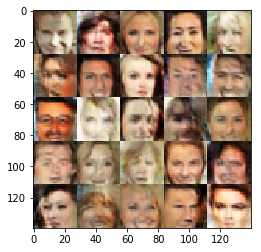

Epoch 1/1 ...  Discriminator Loss: 1.4344 Generator Loss: 0.5263
Epoch 1/1 ...  Discriminator Loss: 1.2571 Generator Loss: 0.6750
Epoch 1/1 ...  Discriminator Loss: 1.2636 Generator Loss: 0.6257
Epoch 1/1 ...  Discriminator Loss: 1.3935 Generator Loss: 0.5329
Epoch 1/1 ...  Discriminator Loss: 1.2225 Generator Loss: 0.8824
Epoch 1/1 ...  Discriminator Loss: 1.3929 Generator Loss: 0.6846
Epoch 1/1 ...  Discriminator Loss: 1.3586 Generator Loss: 0.5036
Epoch 1/1 ...  Discriminator Loss: 1.3832 Generator Loss: 0.5358
Epoch 1/1 ...  Discriminator Loss: 2.1964 Generator Loss: 0.2528
Epoch 1/1 ...  Discriminator Loss: 1.3566 Generator Loss: 0.6144


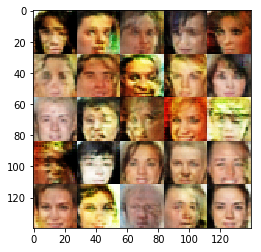

Epoch 1/1 ...  Discriminator Loss: 1.0088 Generator Loss: 0.8815
Epoch 1/1 ...  Discriminator Loss: 1.1080 Generator Loss: 0.9349
Epoch 1/1 ...  Discriminator Loss: 1.2459 Generator Loss: 0.6860
Epoch 1/1 ...  Discriminator Loss: 1.8595 Generator Loss: 0.3262
Epoch 1/1 ...  Discriminator Loss: 1.4610 Generator Loss: 0.4908
Epoch 1/1 ...  Discriminator Loss: 1.3408 Generator Loss: 0.5829
Epoch 1/1 ...  Discriminator Loss: 1.6051 Generator Loss: 0.7068
Epoch 1/1 ...  Discriminator Loss: 1.2496 Generator Loss: 0.8119
Epoch 1/1 ...  Discriminator Loss: 0.7436 Generator Loss: 1.3127
Epoch 1/1 ...  Discriminator Loss: 1.4794 Generator Loss: 0.4911


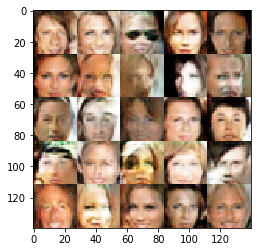

Epoch 1/1 ...  Discriminator Loss: 1.3248 Generator Loss: 0.6428
Epoch 1/1 ...  Discriminator Loss: 1.5517 Generator Loss: 0.5186
Epoch 1/1 ...  Discriminator Loss: 0.9569 Generator Loss: 1.0657
Epoch 1/1 ...  Discriminator Loss: 1.1364 Generator Loss: 0.6753
Epoch 1/1 ...  Discriminator Loss: 1.4499 Generator Loss: 0.6637
Epoch 1/1 ...  Discriminator Loss: 1.1193 Generator Loss: 0.7966
Epoch 1/1 ...  Discriminator Loss: 1.4952 Generator Loss: 0.5650
Epoch 1/1 ...  Discriminator Loss: 1.1724 Generator Loss: 0.7484
Epoch 1/1 ...  Discriminator Loss: 1.6353 Generator Loss: 0.4376
Epoch 1/1 ...  Discriminator Loss: 1.2880 Generator Loss: 0.8856


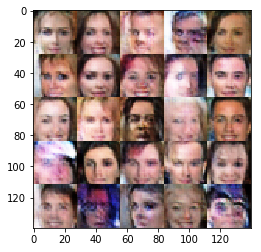

Epoch 1/1 ...  Discriminator Loss: 1.3745 Generator Loss: 0.5873
Epoch 1/1 ...  Discriminator Loss: 1.4638 Generator Loss: 1.2128
Epoch 1/1 ...  Discriminator Loss: 0.9281 Generator Loss: 0.8704
Epoch 1/1 ...  Discriminator Loss: 1.3567 Generator Loss: 0.5916
Epoch 1/1 ...  Discriminator Loss: 1.7447 Generator Loss: 0.3660
Epoch 1/1 ...  Discriminator Loss: 1.4906 Generator Loss: 0.5085
Epoch 1/1 ...  Discriminator Loss: 1.4153 Generator Loss: 0.5256
Epoch 1/1 ...  Discriminator Loss: 1.2282 Generator Loss: 0.8137
Epoch 1/1 ...  Discriminator Loss: 1.4467 Generator Loss: 0.5600
Epoch 1/1 ...  Discriminator Loss: 1.2381 Generator Loss: 0.6669


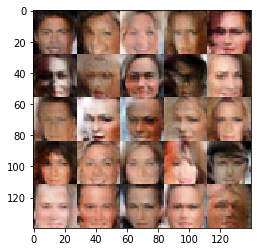

Epoch 1/1 ...  Discriminator Loss: 1.3171 Generator Loss: 0.6043
Epoch 1/1 ...  Discriminator Loss: 1.1318 Generator Loss: 0.9363
Epoch 1/1 ...  Discriminator Loss: 1.5293 Generator Loss: 0.4677
Epoch 1/1 ...  Discriminator Loss: 1.2934 Generator Loss: 0.5799
Epoch 1/1 ...  Discriminator Loss: 1.0015 Generator Loss: 0.6734
Epoch 1/1 ...  Discriminator Loss: 1.4835 Generator Loss: 0.5789
Epoch 1/1 ...  Discriminator Loss: 1.4516 Generator Loss: 0.5451
Epoch 1/1 ...  Discriminator Loss: 1.4975 Generator Loss: 0.6508
Epoch 1/1 ...  Discriminator Loss: 1.1851 Generator Loss: 0.7574
Epoch 1/1 ...  Discriminator Loss: 1.3444 Generator Loss: 0.6714


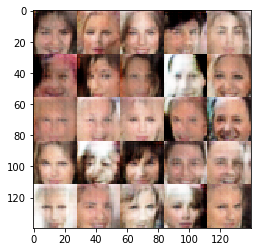

Epoch 1/1 ...  Discriminator Loss: 1.3594 Generator Loss: 0.6778
Epoch 1/1 ...  Discriminator Loss: 1.3245 Generator Loss: 0.7466
Epoch 1/1 ...  Discriminator Loss: 1.4461 Generator Loss: 1.1202
Epoch 1/1 ...  Discriminator Loss: 2.0534 Generator Loss: 0.2761
Epoch 1/1 ...  Discriminator Loss: 1.3401 Generator Loss: 0.5937
Epoch 1/1 ...  Discriminator Loss: 1.4627 Generator Loss: 0.5557
Epoch 1/1 ...  Discriminator Loss: 1.1868 Generator Loss: 0.6705
Epoch 1/1 ...  Discriminator Loss: 1.2708 Generator Loss: 0.6445
Epoch 1/1 ...  Discriminator Loss: 1.3129 Generator Loss: 0.7654
Epoch 1/1 ...  Discriminator Loss: 1.3548 Generator Loss: 0.6307


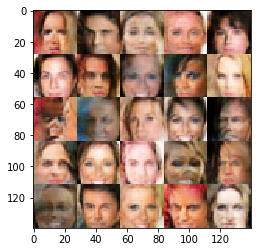

Epoch 1/1 ...  Discriminator Loss: 1.2972 Generator Loss: 0.6629
Epoch 1/1 ...  Discriminator Loss: 1.4500 Generator Loss: 0.5719
Epoch 1/1 ...  Discriminator Loss: 1.2324 Generator Loss: 0.8395
Epoch 1/1 ...  Discriminator Loss: 1.3973 Generator Loss: 0.6488
Epoch 1/1 ...  Discriminator Loss: 1.3836 Generator Loss: 0.5608
Epoch 1/1 ...  Discriminator Loss: 1.3258 Generator Loss: 0.7076
Epoch 1/1 ...  Discriminator Loss: 1.1751 Generator Loss: 0.7918
Epoch 1/1 ...  Discriminator Loss: 1.3197 Generator Loss: 0.6800
Epoch 1/1 ...  Discriminator Loss: 1.3782 Generator Loss: 0.6375
Epoch 1/1 ...  Discriminator Loss: 0.5605 Generator Loss: 1.6068


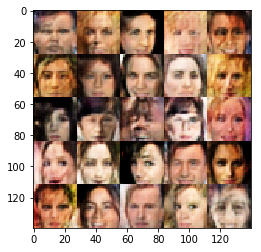

Epoch 1/1 ...  Discriminator Loss: 1.4282 Generator Loss: 0.5591
Epoch 1/1 ...  Discriminator Loss: 1.6257 Generator Loss: 1.0295
Epoch 1/1 ...  Discriminator Loss: 1.2668 Generator Loss: 0.7923
Epoch 1/1 ...  Discriminator Loss: 1.3428 Generator Loss: 0.7364
Epoch 1/1 ...  Discriminator Loss: 1.0878 Generator Loss: 0.8284
Epoch 1/1 ...  Discriminator Loss: 0.9381 Generator Loss: 1.5665
Epoch 1/1 ...  Discriminator Loss: 1.2794 Generator Loss: 0.7752
Epoch 1/1 ...  Discriminator Loss: 1.4204 Generator Loss: 0.5923
Epoch 1/1 ...  Discriminator Loss: 1.3911 Generator Loss: 0.7843
Epoch 1/1 ...  Discriminator Loss: 0.5290 Generator Loss: 1.7038


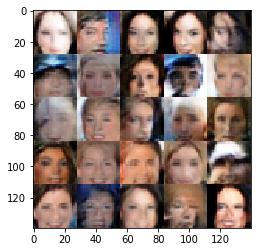

Epoch 1/1 ...  Discriminator Loss: 1.2403 Generator Loss: 0.7219
Epoch 1/1 ...  Discriminator Loss: 1.4992 Generator Loss: 0.5075
Epoch 1/1 ...  Discriminator Loss: 1.2719 Generator Loss: 0.6515
Epoch 1/1 ...  Discriminator Loss: 1.4621 Generator Loss: 0.6343
Epoch 1/1 ...  Discriminator Loss: 1.4071 Generator Loss: 0.5937
Epoch 1/1 ...  Discriminator Loss: 1.0914 Generator Loss: 1.3198
Epoch 1/1 ...  Discriminator Loss: 1.6099 Generator Loss: 0.4429
Epoch 1/1 ...  Discriminator Loss: 1.3184 Generator Loss: 0.6014
Epoch 1/1 ...  Discriminator Loss: 1.4139 Generator Loss: 0.6476
Epoch 1/1 ...  Discriminator Loss: 1.2756 Generator Loss: 0.8765


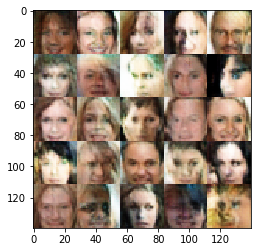

Epoch 1/1 ...  Discriminator Loss: 1.2753 Generator Loss: 0.6453
Epoch 1/1 ...  Discriminator Loss: 1.3319 Generator Loss: 0.5702
Epoch 1/1 ...  Discriminator Loss: 1.3629 Generator Loss: 0.6446
Epoch 1/1 ...  Discriminator Loss: 1.3640 Generator Loss: 0.6828
Epoch 1/1 ...  Discriminator Loss: 1.0390 Generator Loss: 1.4832
Epoch 1/1 ...  Discriminator Loss: 0.9706 Generator Loss: 0.8262
Epoch 1/1 ...  Discriminator Loss: 1.4845 Generator Loss: 0.4484
Epoch 1/1 ...  Discriminator Loss: 1.2871 Generator Loss: 0.7049
Epoch 1/1 ...  Discriminator Loss: 1.3594 Generator Loss: 0.5924
Epoch 1/1 ...  Discriminator Loss: 1.4204 Generator Loss: 0.6027


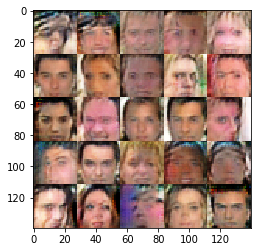

Epoch 1/1 ...  Discriminator Loss: 1.3898 Generator Loss: 0.6709
Epoch 1/1 ...  Discriminator Loss: 1.3345 Generator Loss: 0.7633
Epoch 1/1 ...  Discriminator Loss: 1.4491 Generator Loss: 0.6150
Epoch 1/1 ...  Discriminator Loss: 1.2307 Generator Loss: 0.6809
Epoch 1/1 ...  Discriminator Loss: 1.3814 Generator Loss: 0.5310
Epoch 1/1 ...  Discriminator Loss: 1.3970 Generator Loss: 0.6580
Epoch 1/1 ...  Discriminator Loss: 1.1915 Generator Loss: 0.7540
Epoch 1/1 ...  Discriminator Loss: 1.5078 Generator Loss: 0.8659
Epoch 1/1 ...  Discriminator Loss: 1.4112 Generator Loss: 0.7227
Epoch 1/1 ...  Discriminator Loss: 1.2393 Generator Loss: 0.6747


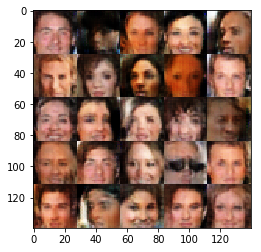

Epoch 1/1 ...  Discriminator Loss: 2.1979 Generator Loss: 2.1022
Epoch 1/1 ...  Discriminator Loss: 1.3702 Generator Loss: 0.6063
Epoch 1/1 ...  Discriminator Loss: 1.2821 Generator Loss: 0.7008
Epoch 1/1 ...  Discriminator Loss: 1.2845 Generator Loss: 0.6441
Epoch 1/1 ...  Discriminator Loss: 1.1891 Generator Loss: 0.7437
Epoch 1/1 ...  Discriminator Loss: 1.2366 Generator Loss: 0.6525
Epoch 1/1 ...  Discriminator Loss: 1.3503 Generator Loss: 0.6857
Epoch 1/1 ...  Discriminator Loss: 1.3296 Generator Loss: 0.8244
Epoch 1/1 ...  Discriminator Loss: 1.4435 Generator Loss: 0.6063
Epoch 1/1 ...  Discriminator Loss: 1.2769 Generator Loss: 0.6373


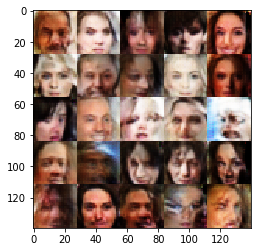

Epoch 1/1 ...  Discriminator Loss: 1.4728 Generator Loss: 0.7576
Epoch 1/1 ...  Discriminator Loss: 1.3984 Generator Loss: 0.6968
Epoch 1/1 ...  Discriminator Loss: 1.0698 Generator Loss: 0.6624
Epoch 1/1 ...  Discriminator Loss: 1.5598 Generator Loss: 0.6268
Epoch 1/1 ...  Discriminator Loss: 1.4137 Generator Loss: 0.6591
Epoch 1/1 ...  Discriminator Loss: 1.1561 Generator Loss: 0.8056
Epoch 1/1 ...  Discriminator Loss: 1.3795 Generator Loss: 0.5430
Epoch 1/1 ...  Discriminator Loss: 1.2426 Generator Loss: 0.7304
Epoch 1/1 ...  Discriminator Loss: 1.4406 Generator Loss: 0.5426
Epoch 1/1 ...  Discriminator Loss: 1.5121 Generator Loss: 0.4629


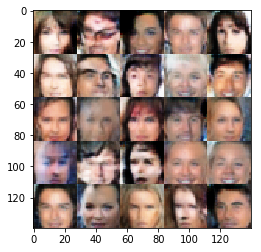

Epoch 1/1 ...  Discriminator Loss: 1.0722 Generator Loss: 1.1260
Epoch 1/1 ...  Discriminator Loss: 1.1420 Generator Loss: 0.6994
Epoch 1/1 ...  Discriminator Loss: 1.4038 Generator Loss: 0.6632
Epoch 1/1 ...  Discriminator Loss: 1.3112 Generator Loss: 0.6413
Epoch 1/1 ...  Discriminator Loss: 1.4048 Generator Loss: 0.5645
Epoch 1/1 ...  Discriminator Loss: 1.3377 Generator Loss: 0.6255
Epoch 1/1 ...  Discriminator Loss: 1.4335 Generator Loss: 0.5542
Epoch 1/1 ...  Discriminator Loss: 1.4461 Generator Loss: 0.5325
Epoch 1/1 ...  Discriminator Loss: 1.2872 Generator Loss: 0.6945
Epoch 1/1 ...  Discriminator Loss: 1.4890 Generator Loss: 0.6051


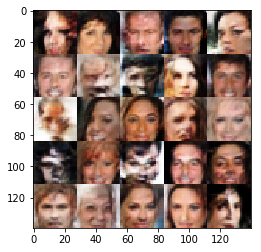

Epoch 1/1 ...  Discriminator Loss: 1.3607 Generator Loss: 0.6326
Epoch 1/1 ...  Discriminator Loss: 0.8314 Generator Loss: 1.0514
Epoch 1/1 ...  Discriminator Loss: 1.4884 Generator Loss: 0.5449
Epoch 1/1 ...  Discriminator Loss: 0.6522 Generator Loss: 1.3673
Epoch 1/1 ...  Discriminator Loss: 1.3608 Generator Loss: 1.3395
Epoch 1/1 ...  Discriminator Loss: 1.3940 Generator Loss: 0.5591
Epoch 1/1 ...  Discriminator Loss: 1.1663 Generator Loss: 0.6849
Epoch 1/1 ...  Discriminator Loss: 1.0553 Generator Loss: 0.8721
Epoch 1/1 ...  Discriminator Loss: 1.1472 Generator Loss: 0.8119
Epoch 1/1 ...  Discriminator Loss: 1.3506 Generator Loss: 0.6878


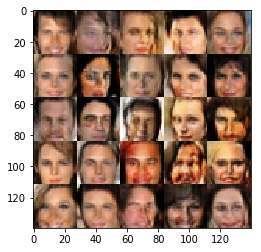

Epoch 1/1 ...  Discriminator Loss: 1.1549 Generator Loss: 0.6925
Epoch 1/1 ...  Discriminator Loss: 1.1986 Generator Loss: 1.5258
Epoch 1/1 ...  Discriminator Loss: 1.4923 Generator Loss: 0.4643
Epoch 1/1 ...  Discriminator Loss: 1.4759 Generator Loss: 0.6225
Epoch 1/1 ...  Discriminator Loss: 1.3092 Generator Loss: 0.7202
Epoch 1/1 ...  Discriminator Loss: 1.3894 Generator Loss: 0.5429
Epoch 1/1 ...  Discriminator Loss: 1.6253 Generator Loss: 0.4826
Epoch 1/1 ...  Discriminator Loss: 1.1983 Generator Loss: 0.6628
Epoch 1/1 ...  Discriminator Loss: 1.4197 Generator Loss: 0.9507
Epoch 1/1 ...  Discriminator Loss: 1.3732 Generator Loss: 0.5887


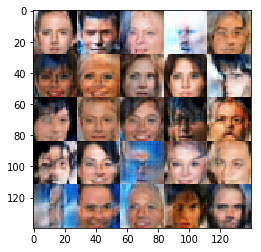

Epoch 1/1 ...  Discriminator Loss: 1.3077 Generator Loss: 0.6148
Epoch 1/1 ...  Discriminator Loss: 1.0698 Generator Loss: 0.7327
Epoch 1/1 ...  Discriminator Loss: 1.3866 Generator Loss: 0.5952
Epoch 1/1 ...  Discriminator Loss: 1.4434 Generator Loss: 0.5899
Epoch 1/1 ...  Discriminator Loss: 1.3374 Generator Loss: 0.6501
Epoch 1/1 ...  Discriminator Loss: 1.2100 Generator Loss: 0.7194
Epoch 1/1 ...  Discriminator Loss: 1.2997 Generator Loss: 0.7663
Epoch 1/1 ...  Discriminator Loss: 1.3979 Generator Loss: 0.7125
Epoch 1/1 ...  Discriminator Loss: 1.3130 Generator Loss: 0.7743
Epoch 1/1 ...  Discriminator Loss: 0.5938 Generator Loss: 1.8626


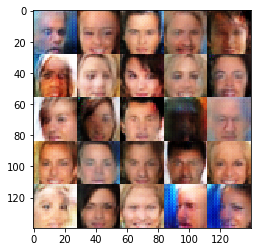

Epoch 1/1 ...  Discriminator Loss: 1.3962 Generator Loss: 0.7124
Epoch 1/1 ...  Discriminator Loss: 1.2581 Generator Loss: 0.7878
Epoch 1/1 ...  Discriminator Loss: 1.3612 Generator Loss: 0.6758
Epoch 1/1 ...  Discriminator Loss: 1.3775 Generator Loss: 0.7129
Epoch 1/1 ...  Discriminator Loss: 1.5180 Generator Loss: 0.5761
Epoch 1/1 ...  Discriminator Loss: 1.3113 Generator Loss: 0.6258
Epoch 1/1 ...  Discriminator Loss: 1.2458 Generator Loss: 0.5967
Epoch 1/1 ...  Discriminator Loss: 0.9089 Generator Loss: 1.1310
Epoch 1/1 ...  Discriminator Loss: 0.7203 Generator Loss: 1.1153
Epoch 1/1 ...  Discriminator Loss: 1.2900 Generator Loss: 0.6162


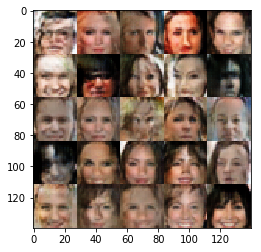

Epoch 1/1 ...  Discriminator Loss: 1.3883 Generator Loss: 0.6244
Epoch 1/1 ...  Discriminator Loss: 1.3385 Generator Loss: 0.7394
Epoch 1/1 ...  Discriminator Loss: 1.2908 Generator Loss: 0.7074
Epoch 1/1 ...  Discriminator Loss: 1.2191 Generator Loss: 0.7844
Epoch 1/1 ...  Discriminator Loss: 1.3499 Generator Loss: 0.6964
Epoch 1/1 ...  Discriminator Loss: 1.5740 Generator Loss: 0.4076
Epoch 1/1 ...  Discriminator Loss: 1.4278 Generator Loss: 0.5299
Epoch 1/1 ...  Discriminator Loss: 1.3026 Generator Loss: 0.6674
Epoch 1/1 ...  Discriminator Loss: 1.4136 Generator Loss: 0.8162
Epoch 1/1 ...  Discriminator Loss: 1.4657 Generator Loss: 0.5186


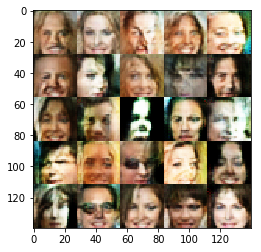

Epoch 1/1 ...  Discriminator Loss: 1.4517 Generator Loss: 0.5440
Epoch 1/1 ...  Discriminator Loss: 1.2484 Generator Loss: 0.6937
Epoch 1/1 ...  Discriminator Loss: 1.1643 Generator Loss: 0.6429
Epoch 1/1 ...  Discriminator Loss: 1.2930 Generator Loss: 0.7427
Epoch 1/1 ...  Discriminator Loss: 1.0550 Generator Loss: 0.9792
Epoch 1/1 ...  Discriminator Loss: 1.3485 Generator Loss: 0.6814
Epoch 1/1 ...  Discriminator Loss: 1.5157 Generator Loss: 0.4676
Epoch 1/1 ...  Discriminator Loss: 1.2297 Generator Loss: 0.6817
Epoch 1/1 ...  Discriminator Loss: 2.0121 Generator Loss: 0.2963
Epoch 1/1 ...  Discriminator Loss: 1.2422 Generator Loss: 0.7636


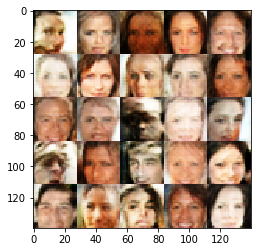

Epoch 1/1 ...  Discriminator Loss: 1.2796 Generator Loss: 0.6669
Epoch 1/1 ...  Discriminator Loss: 1.4643 Generator Loss: 0.5259
Epoch 1/1 ...  Discriminator Loss: 1.0614 Generator Loss: 0.7592
Epoch 1/1 ...  Discriminator Loss: 1.1750 Generator Loss: 1.0658
Epoch 1/1 ...  Discriminator Loss: 1.4519 Generator Loss: 0.5532
Epoch 1/1 ...  Discriminator Loss: 1.3695 Generator Loss: 0.6378
Epoch 1/1 ...  Discriminator Loss: 1.3264 Generator Loss: 0.7508
Epoch 1/1 ...  Discriminator Loss: 1.2805 Generator Loss: 0.6145
Epoch 1/1 ...  Discriminator Loss: 1.3291 Generator Loss: 0.6730
Epoch 1/1 ...  Discriminator Loss: 1.2966 Generator Loss: 0.9011


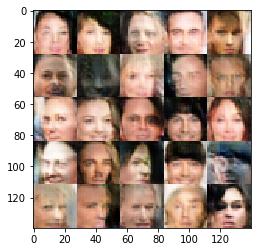

Epoch 1/1 ...  Discriminator Loss: 1.0547 Generator Loss: 0.8050
Epoch 1/1 ...  Discriminator Loss: 1.5405 Generator Loss: 0.4249
Epoch 1/1 ...  Discriminator Loss: 1.3576 Generator Loss: 1.1817
Epoch 1/1 ...  Discriminator Loss: 1.3203 Generator Loss: 0.6860
Epoch 1/1 ...  Discriminator Loss: 1.4009 Generator Loss: 0.6539
Epoch 1/1 ...  Discriminator Loss: 1.2602 Generator Loss: 0.6743
Epoch 1/1 ...  Discriminator Loss: 1.3347 Generator Loss: 0.5989
Epoch 1/1 ...  Discriminator Loss: 1.2614 Generator Loss: 0.9710
Epoch 1/1 ...  Discriminator Loss: 1.4570 Generator Loss: 0.5325
Epoch 1/1 ...  Discriminator Loss: 1.2777 Generator Loss: 0.7460


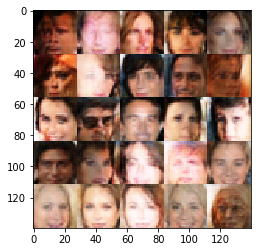

Epoch 1/1 ...  Discriminator Loss: 0.7075 Generator Loss: 1.1025
Epoch 1/1 ...  Discriminator Loss: 1.6981 Generator Loss: 1.1287
Epoch 1/1 ...  Discriminator Loss: 1.4956 Generator Loss: 0.5157
Epoch 1/1 ...  Discriminator Loss: 1.1707 Generator Loss: 0.7156
Epoch 1/1 ...  Discriminator Loss: 1.2712 Generator Loss: 0.6797
Epoch 1/1 ...  Discriminator Loss: 1.1233 Generator Loss: 0.7903
Epoch 1/1 ...  Discriminator Loss: 1.1633 Generator Loss: 0.6889
Epoch 1/1 ...  Discriminator Loss: 1.3157 Generator Loss: 0.6483
Epoch 1/1 ...  Discriminator Loss: 1.4272 Generator Loss: 0.5310
Epoch 1/1 ...  Discriminator Loss: 1.3042 Generator Loss: 0.6759


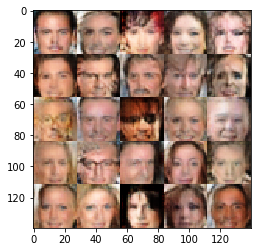

Epoch 1/1 ...  Discriminator Loss: 1.2688 Generator Loss: 0.5865
Epoch 1/1 ...  Discriminator Loss: 1.3036 Generator Loss: 0.8377
Epoch 1/1 ...  Discriminator Loss: 1.4638 Generator Loss: 0.5262
Epoch 1/1 ...  Discriminator Loss: 1.4282 Generator Loss: 0.6530
Epoch 1/1 ...  Discriminator Loss: 1.3857 Generator Loss: 0.7717
Epoch 1/1 ...  Discriminator Loss: 0.7478 Generator Loss: 1.0453
Epoch 1/1 ...  Discriminator Loss: 1.4827 Generator Loss: 0.6063
Epoch 1/1 ...  Discriminator Loss: 1.2311 Generator Loss: 0.7474
Epoch 1/1 ...  Discriminator Loss: 1.1299 Generator Loss: 0.9959
Epoch 1/1 ...  Discriminator Loss: 1.5540 Generator Loss: 0.4857


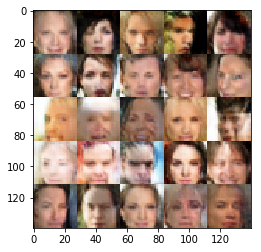

Epoch 1/1 ...  Discriminator Loss: 0.6218 Generator Loss: 1.6198
Epoch 1/1 ...  Discriminator Loss: 1.4104 Generator Loss: 0.5202
Epoch 1/1 ...  Discriminator Loss: 1.3507 Generator Loss: 0.6031
Epoch 1/1 ...  Discriminator Loss: 1.6179 Generator Loss: 0.7682
Epoch 1/1 ...  Discriminator Loss: 1.6468 Generator Loss: 0.4955
Epoch 1/1 ...  Discriminator Loss: 1.3297 Generator Loss: 0.7021
Epoch 1/1 ...  Discriminator Loss: 1.2980 Generator Loss: 0.7093
Epoch 1/1 ...  Discriminator Loss: 1.2474 Generator Loss: 0.6418
Epoch 1/1 ...  Discriminator Loss: 1.4707 Generator Loss: 0.5227
Epoch 1/1 ...  Discriminator Loss: 1.4961 Generator Loss: 0.4969


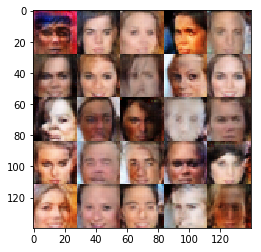

Epoch 1/1 ...  Discriminator Loss: 0.8764 Generator Loss: 1.2658
Epoch 1/1 ...  Discriminator Loss: 1.5559 Generator Loss: 0.6093
Epoch 1/1 ...  Discriminator Loss: 1.6469 Generator Loss: 0.4770
Epoch 1/1 ...  Discriminator Loss: 1.5019 Generator Loss: 0.4224
Epoch 1/1 ...  Discriminator Loss: 1.4202 Generator Loss: 0.5545
Epoch 1/1 ...  Discriminator Loss: 1.2483 Generator Loss: 0.7249
Epoch 1/1 ...  Discriminator Loss: 1.1309 Generator Loss: 0.7386
Epoch 1/1 ...  Discriminator Loss: 1.1476 Generator Loss: 0.9821
Epoch 1/1 ...  Discriminator Loss: 1.0117 Generator Loss: 0.7938
Epoch 1/1 ...  Discriminator Loss: 0.9830 Generator Loss: 0.7661


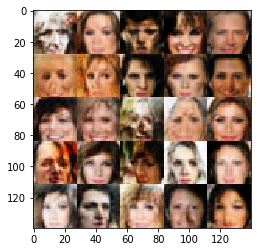

Epoch 1/1 ...  Discriminator Loss: 1.4798 Generator Loss: 0.5181
Epoch 1/1 ...  Discriminator Loss: 1.5631 Generator Loss: 0.5021
Epoch 1/1 ...  Discriminator Loss: 1.2969 Generator Loss: 0.5914
Epoch 1/1 ...  Discriminator Loss: 1.3679 Generator Loss: 0.6480
Epoch 1/1 ...  Discriminator Loss: 1.3058 Generator Loss: 0.7302
Epoch 1/1 ...  Discriminator Loss: 1.3274 Generator Loss: 0.6455
Epoch 1/1 ...  Discriminator Loss: 1.4623 Generator Loss: 0.5091
Epoch 1/1 ...  Discriminator Loss: 1.2510 Generator Loss: 0.6507
Epoch 1/1 ...  Discriminator Loss: 1.2210 Generator Loss: 0.7580
Epoch 1/1 ...  Discriminator Loss: 1.3244 Generator Loss: 0.5432


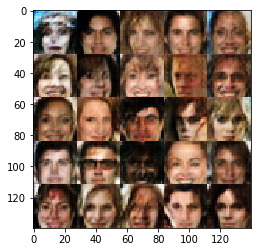

Epoch 1/1 ...  Discriminator Loss: 0.9812 Generator Loss: 1.1075
Epoch 1/1 ...  Discriminator Loss: 1.2028 Generator Loss: 0.7237
Epoch 1/1 ...  Discriminator Loss: 1.5204 Generator Loss: 0.4681
Epoch 1/1 ...  Discriminator Loss: 1.4496 Generator Loss: 0.6047
Epoch 1/1 ...  Discriminator Loss: 1.4051 Generator Loss: 0.8834
Epoch 1/1 ...  Discriminator Loss: 1.3938 Generator Loss: 1.2300
Epoch 1/1 ...  Discriminator Loss: 1.2776 Generator Loss: 0.5970
Epoch 1/1 ...  Discriminator Loss: 1.2913 Generator Loss: 0.8268
Epoch 1/1 ...  Discriminator Loss: 1.4919 Generator Loss: 0.6024
Epoch 1/1 ...  Discriminator Loss: 1.4234 Generator Loss: 0.6509


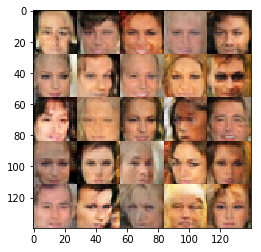

Epoch 1/1 ...  Discriminator Loss: 1.0559 Generator Loss: 0.7435
Epoch 1/1 ...  Discriminator Loss: 1.5516 Generator Loss: 0.4271
Epoch 1/1 ...  Discriminator Loss: 1.4250 Generator Loss: 0.5720
Epoch 1/1 ...  Discriminator Loss: 1.1520 Generator Loss: 0.9698
Epoch 1/1 ...  Discriminator Loss: 1.2169 Generator Loss: 0.6774
Epoch 1/1 ...  Discriminator Loss: 1.2673 Generator Loss: 0.8134
Epoch 1/1 ...  Discriminator Loss: 1.3910 Generator Loss: 0.6755
Epoch 1/1 ...  Discriminator Loss: 1.2326 Generator Loss: 0.6955
Epoch 1/1 ...  Discriminator Loss: 1.6208 Generator Loss: 0.3860
Epoch 1/1 ...  Discriminator Loss: 1.6559 Generator Loss: 0.4245


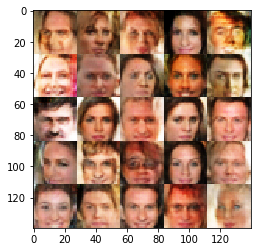

Epoch 1/1 ...  Discriminator Loss: 1.2317 Generator Loss: 0.8110
Epoch 1/1 ...  Discriminator Loss: 0.6744 Generator Loss: 1.9798
Epoch 1/1 ...  Discriminator Loss: 1.3611 Generator Loss: 0.5689
Epoch 1/1 ...  Discriminator Loss: 1.3090 Generator Loss: 0.7148
Epoch 1/1 ...  Discriminator Loss: 1.4821 Generator Loss: 0.4824
Epoch 1/1 ...  Discriminator Loss: 1.2282 Generator Loss: 0.6797
Epoch 1/1 ...  Discriminator Loss: 1.4857 Generator Loss: 0.5407
Epoch 1/1 ...  Discriminator Loss: 1.4036 Generator Loss: 0.6082
Epoch 1/1 ...  Discriminator Loss: 1.4538 Generator Loss: 0.5617
Epoch 1/1 ...  Discriminator Loss: 1.0796 Generator Loss: 0.9713


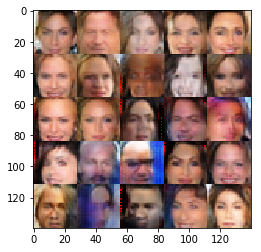

Epoch 1/1 ...  Discriminator Loss: 2.0777 Generator Loss: 0.2762
Epoch 1/1 ...  Discriminator Loss: 1.2789 Generator Loss: 0.6830
Epoch 1/1 ...  Discriminator Loss: 0.8967 Generator Loss: 0.9308
Epoch 1/1 ...  Discriminator Loss: 1.4986 Generator Loss: 0.4555
Epoch 1/1 ...  Discriminator Loss: 1.2899 Generator Loss: 0.6780
Epoch 1/1 ...  Discriminator Loss: 1.3325 Generator Loss: 0.7207
Epoch 1/1 ...  Discriminator Loss: 1.2537 Generator Loss: 0.6924
Epoch 1/1 ...  Discriminator Loss: 1.4365 Generator Loss: 0.5767
Epoch 1/1 ...  Discriminator Loss: 1.5570 Generator Loss: 0.6348
Epoch 1/1 ...  Discriminator Loss: 1.4081 Generator Loss: 0.6726


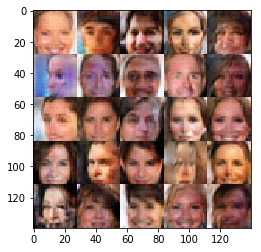

Epoch 1/1 ...  Discriminator Loss: 1.4201 Generator Loss: 0.6606
Epoch 1/1 ...  Discriminator Loss: 1.5485 Generator Loss: 0.5126
Epoch 1/1 ...  Discriminator Loss: 1.3651 Generator Loss: 0.6324
Epoch 1/1 ...  Discriminator Loss: 1.3626 Generator Loss: 0.6533
Epoch 1/1 ...  Discriminator Loss: 1.2061 Generator Loss: 0.7716
Epoch 1/1 ...  Discriminator Loss: 1.2862 Generator Loss: 0.6907
Epoch 1/1 ...  Discriminator Loss: 1.2998 Generator Loss: 0.6279
Epoch 1/1 ...  Discriminator Loss: 1.2717 Generator Loss: 0.6347
Epoch 1/1 ...  Discriminator Loss: 1.5077 Generator Loss: 0.5817
Epoch 1/1 ...  Discriminator Loss: 1.0488 Generator Loss: 1.2327


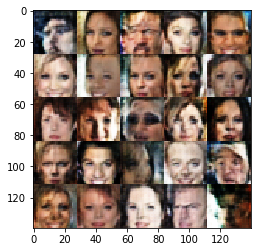

Epoch 1/1 ...  Discriminator Loss: 1.2420 Generator Loss: 0.8798
Epoch 1/1 ...  Discriminator Loss: 1.3726 Generator Loss: 0.7214
Epoch 1/1 ...  Discriminator Loss: 1.3033 Generator Loss: 0.8126
Epoch 1/1 ...  Discriminator Loss: 1.3928 Generator Loss: 0.6583
Epoch 1/1 ...  Discriminator Loss: 1.2261 Generator Loss: 0.7361
Epoch 1/1 ...  Discriminator Loss: 1.1877 Generator Loss: 0.7007
Epoch 1/1 ...  Discriminator Loss: 2.4468 Generator Loss: 0.2341
Epoch 1/1 ...  Discriminator Loss: 1.1442 Generator Loss: 0.8211
Epoch 1/1 ...  Discriminator Loss: 1.5374 Generator Loss: 0.4654
Epoch 1/1 ...  Discriminator Loss: 1.3686 Generator Loss: 0.5860


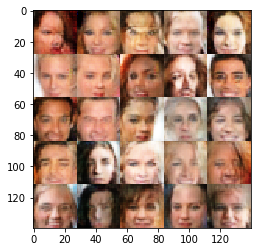

Epoch 1/1 ...  Discriminator Loss: 1.1892 Generator Loss: 0.7866
Epoch 1/1 ...  Discriminator Loss: 1.4652 Generator Loss: 0.6112
Epoch 1/1 ...  Discriminator Loss: 1.3757 Generator Loss: 0.5603


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)